# Import

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
register_matplotlib_converters()

# Read Data

In [3]:
data_all = pd.read_csv('data_summarized_by_month_Kravets.tsv', sep='\t')
data_all

,hosp,type,year,month,Всего_с_ОНМК,Не_подтвержден_ОНМК,Госпитализированы_с_ОНМК,Пролечены_с_ОНМК_Всего,Внутрибольничные_ОНМК,ИИ_Ишемический_Инсульт,...,ГИ_Всего,Летальные_Исходы,Летальные_Исходы_1_Сутки,Выписаны_Всего,Ривермид_1_Балл,Ривермид_2_4_Балла,Ривермид_5_8_Баллов,Ривермид_9_Баллов,Суммарная_Загрузка_ОНМК,Суммарно_Госпитализировано
0,alm,3,2017,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,alm,3,2017,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,alm,3,2017,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,alm,3,2017,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,alm,3,2017,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,med1,3,2024,8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1544,med1,3,2024,9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1545,med1,3,2024,10,26.0,3.0,23.0,7.0,3.0,5.0,...,0.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,26.0,23.0
1546,med1,3,2024,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
import bioreactor
bioreactor.__version__

'0.3.3'

In [5]:
import numba
numba.__version__

'0.59.1'

## Selecting hospitals

In [6]:
group_rsc = ['bsp', 'gvv', 'b2']
group_pso = ['b15']

group_together = ['bsp', 'gvv', 'b2', 'b15']
group_together_graph = ['BSP', 'GVV', 'B2', 'B15']

In [7]:
data_all['hosp_graph'] = data_all['hosp'].replace(group_together, group_together_graph)

In [8]:
palette_ = {'bsp': '#FF5733', 'gvv': '#459c67', 'b2': '#3357FF', 'b15': '#993b88', "GVV_BSP_B2":"#514f41"}
palette = {'BSP': '#FF5733', 'GVV': '#459c67', 'B2': '#3357FF', 'B15': '#993b88', "GVV_BSP_B2":"#514f41"}

In [9]:
data_used = data_all.loc[data_all.hosp.isin(group_together)].dropna()

In [10]:
data_used.loc[:, 'Date'] = pd.to_datetime(data_used[['year', 'month']].assign(Day=1))
data_used.loc[:, 'Date_Graph'] = pd.to_datetime(data_used[['year', 'month']].assign(Day=1)).dt.strftime('%Y-%m')

# First Plottings

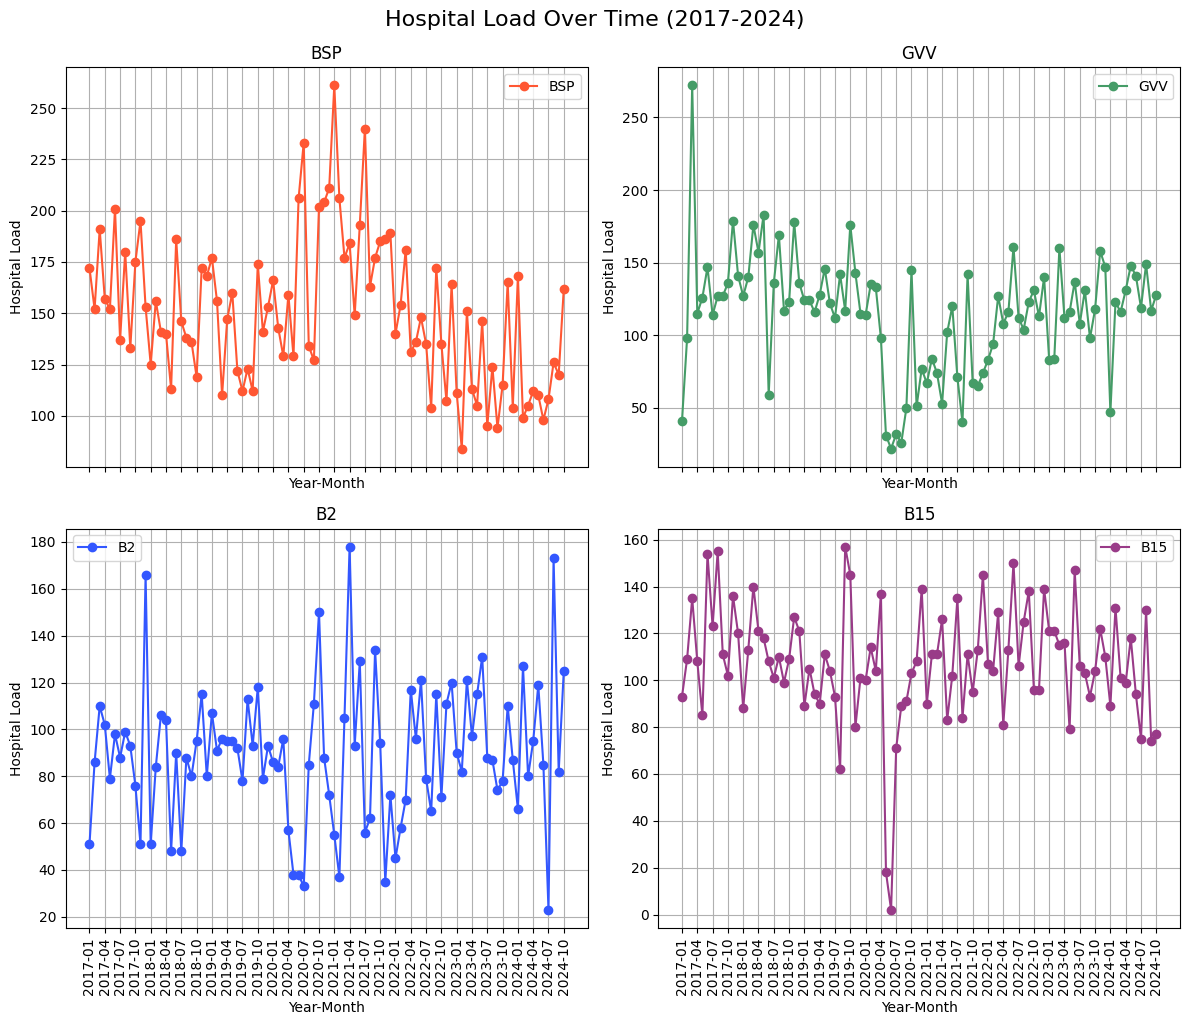

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
ax = ax.flatten()

for i, hospital in enumerate(group_together_graph):
    data_plot = data_used.loc[data_used.hosp_graph == hospital]
    ax[i].plot(data_plot['Date_Graph'], data_plot["Пролечены_с_ОНМК_Всего"], 
             label=hospital, marker='o', color=palette[hospital])

    ax[i].set_title(hospital)
    ax[i].set_xlabel("Year-Month")
    
    xticks = np.arange(len(data_plot.Date_Graph))  # Index positions
    skip_ticks = xticks[::3]  # Take every second tick
    ax[i].set_xticks(skip_ticks)
    
    ax[i].set_xticklabels([data_plot.Date_Graph.to_list()[j] for j in skip_ticks], rotation=90)
    ax[i].set_ylabel("Hospital Load")
    ax[i].grid()
    ax[i].legend()

plt.tight_layout()
plt.suptitle("Hospital Load Over Time (2017-2024)", fontsize=16, y=1.02)
plt.show()

## Dickey-Fuller test

In [12]:
from statsmodels.tsa.stattools import adfuller

### With 2020 year

In [44]:
for i, hospital in enumerate(group_together):
    data_plot = data_used.loc[data_used.hosp == hospital]
    data_plot.set_index('Date', inplace=True)
    data_plot = data_plot.dropna().fillna(0)

    # Perform the Dickey-Fuller test
    result = adfuller(data_plot['Пролечены_с_ОНМК_Всего'])
    
    # Display results
    print(f'*** {hospital} ***')
    print("Dickey-Fuller Test Results:")
    print(f"Test Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Number of Lags Used: {result[2]}")
    print(f"Number of Observations Used: {result[3]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")

*** bsp ***
Dickey-Fuller Test Results:
Test Statistic: -1.5235150039374898
p-value: 0.5218483980883001
Number of Lags Used: 5
Number of Observations Used: 88
Critical Values:
   1%: -3.506944401824286
   5%: -2.894989819214876
   10%: -2.584614550619835
*** gvv ***
Dickey-Fuller Test Results:
Test Statistic: -3.072114949144294
p-value: 0.028686819642899358
Number of Lags Used: 2
Number of Observations Used: 91
Critical Values:
   1%: -3.50434289821397
   5%: -2.8938659630479413
   10%: -2.5840147047458037
*** b2 ***
Dickey-Fuller Test Results:
Test Statistic: -3.1709628927599467
p-value: 0.021728194864234173
Number of Lags Used: 5
Number of Observations Used: 88
Critical Values:
   1%: -3.506944401824286
   5%: -2.894989819214876
   10%: -2.584614550619835
*** b15 ***
Dickey-Fuller Test Results:
Test Statistic: -8.131239181113626
p-value: 1.0888188885050387e-12
Number of Lags Used: 0
Number of Observations Used: 93
Critical Values:
   1%: -3.502704609582561
   5%: -2.8931578098779522


### Without 2020&2021 year

In [14]:
exclude_date_start = pd.to_datetime("2020-01-01")
exclude_date_end = pd.to_datetime("2021-12-01")

In [15]:
for i, hospital in enumerate(group_together):
    data_plot = data_used.loc[data_used.hosp == hospital]
    data_plot = data_plot.loc[~((data_plot.Date < exclude_date_end) & (data_plot.Date > exclude_date_start))]
    data_plot.set_index('Date', inplace=True)
    data_plot = data_plot.dropna().fillna(0)

    # Perform the Dickey-Fuller test
    result = adfuller(data_plot['Пролечены_с_ОНМК_Всего'])
    
    # Display results
    print(f'*** {hospital} ***')
    print("Dickey-Fuller Test Results:")
    print(f"Test Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Number of Lags Used: {result[2]}")
    print(f"Number of Observations Used: {result[3]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")

*** bsp ***
Dickey-Fuller Test Results:
Test Statistic: -2.782612165198286
p-value: 0.060800742387816784
Number of Lags Used: 2
Number of Observations Used: 69
Critical Values:
   1%: -3.528889992207215
   5%: -2.9044395987933362
   10%: -2.589655654274312
*** gvv ***
Dickey-Fuller Test Results:
Test Statistic: -8.834436900130855
p-value: 1.7344556318170573e-14
Number of Lags Used: 0
Number of Observations Used: 71
Critical Values:
   1%: -3.526004646825607
   5%: -2.9032002348069774
   10%: -2.5889948363419957
*** b2 ***
Dickey-Fuller Test Results:
Test Statistic: -10.696637123285944
p-value: 3.6106517434433467e-19
Number of Lags Used: 0
Number of Observations Used: 71
Critical Values:
   1%: -3.526004646825607
   5%: -2.9032002348069774
   10%: -2.5889948363419957
*** b15 ***
Dickey-Fuller Test Results:
Test Statistic: -7.340765315924048
p-value: 1.0667118145555701e-10
Number of Lags Used: 1
Number of Observations Used: 70
Critical Values:
   1%: -3.5274258688046647
   5%: -2.9038108

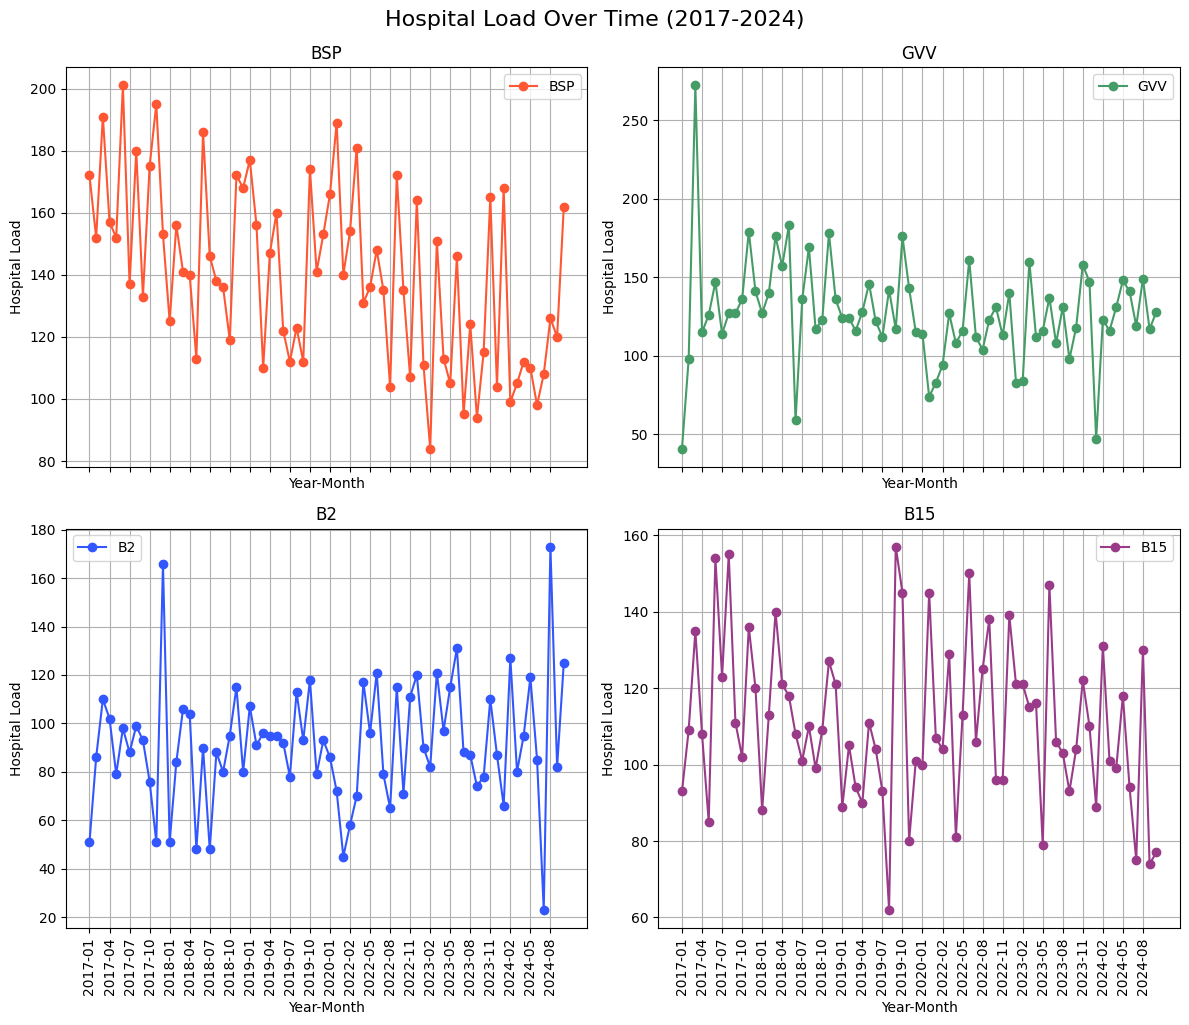

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
ax = ax.flatten()

for i, hospital in enumerate(group_together_graph):
    data_plot = data_used.loc[data_used.hosp_graph == hospital]
    data_plot = data_plot.loc[~((data_plot.Date < exclude_date_end) & (data_plot.Date > exclude_date_start))]
    ax[i].plot(data_plot['Date_Graph'], data_plot["Пролечены_с_ОНМК_Всего"], 
             label=hospital, marker='o', color=palette[hospital])

    ax[i].set_title(hospital)
    ax[i].set_xlabel("Year-Month")
    
    xticks = np.arange(len(data_plot.Date_Graph))  # Index positions
    skip_ticks = xticks[::3]  # Take every second tick
    ax[i].set_xticks(skip_ticks)
    
    ax[i].set_xticklabels([data_plot.Date_Graph.to_list()[j] for j in skip_ticks], rotation=90)
    ax[i].set_ylabel("Hospital Load")
    ax[i].grid()
    ax[i].legend()

plt.tight_layout()
plt.suptitle("Hospital Load Over Time (2017-2024)", fontsize=16, y=1.02)
plt.show()

# Let's take RSC together

In [17]:
# Комбинируем вместе
data_rsc = data_used.loc[data_used.hosp.isin(group_rsc)]
data_rsc = data_rsc.groupby(['Date', 'Date_Graph', 'year', 'month']).sum().reset_index()
data_rsc['hosp'] = "GVV_BSP_B2"

# берем только 2023 год
data_rsc_train = data_rsc.loc[data_rsc.Date < pd.to_datetime("2024-01-01")]
data_rsc_test = data_rsc.loc[data_rsc.Date >= pd.to_datetime("2024-01-01")]

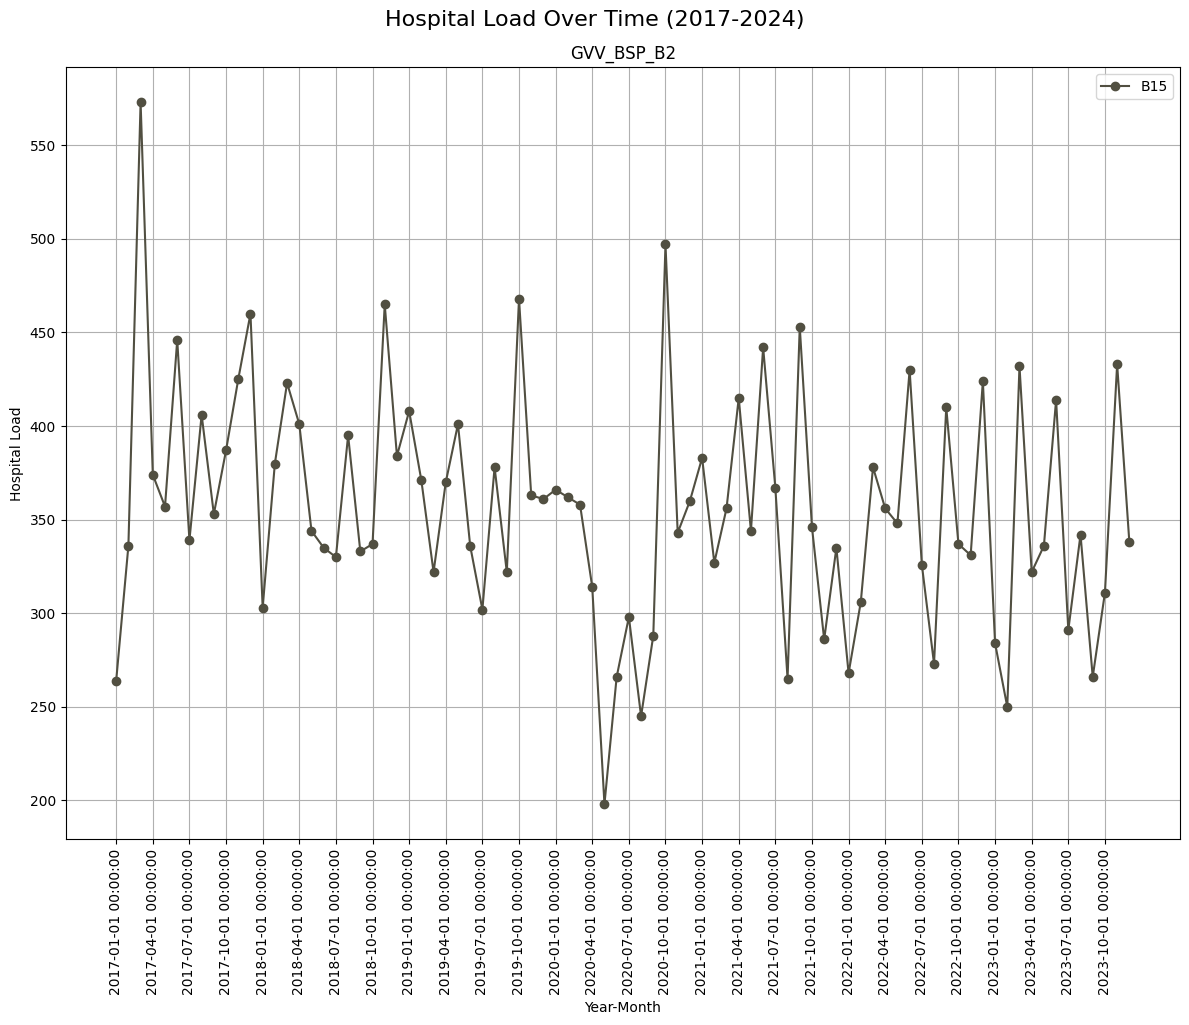

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10), sharex=True)

data_plot = data_rsc_train.copy()
ax.plot(data_plot['Date_Graph'], data_plot["Пролечены_с_ОНМК_Всего"], 
         label=hospital, marker='o', color=palette["GVV_BSP_B2"])

ax.set_title("GVV_BSP_B2")
ax.set_xlabel("Year-Month")

xticks = np.arange(len(data_plot.Date))  # Index positions
skip_ticks = xticks[::3]  # Take every second tick
ax.set_xticks(skip_ticks)

ax.set_xticklabels([data_plot.Date.to_list()[j] for j in skip_ticks], rotation=90)
ax.set_ylabel("Hospital Load")
ax.grid()
ax.legend()

plt.tight_layout()
plt.suptitle("Hospital Load Over Time (2017-2024)", fontsize=16, y=1.02)
plt.show()

In [19]:
data_plot = data_rsc_train.copy()
data_plot.set_index('Date', inplace=True)
data_plot = data_plot.dropna().fillna(0)

# Perform the Dickey-Fuller test
result = adfuller(data_plot['Пролечены_с_ОНМК_Всего'])

# Display results
print(f'*** {hospital} ***')
print("Dickey-Fuller Test Results:")
print(f"Test Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Number of Lags Used: {result[2]}")
print(f"Number of Observations Used: {result[3]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

*** B15 ***
Dickey-Fuller Test Results:
Test Statistic: -4.3313879991676565
p-value: 0.0003917844700443421
Number of Lags Used: 3
Number of Observations Used: 80
Critical Values:
   1%: -3.5148692050781247
   5%: -2.8984085156250003
   10%: -2.58643890625


## Plot by month each year

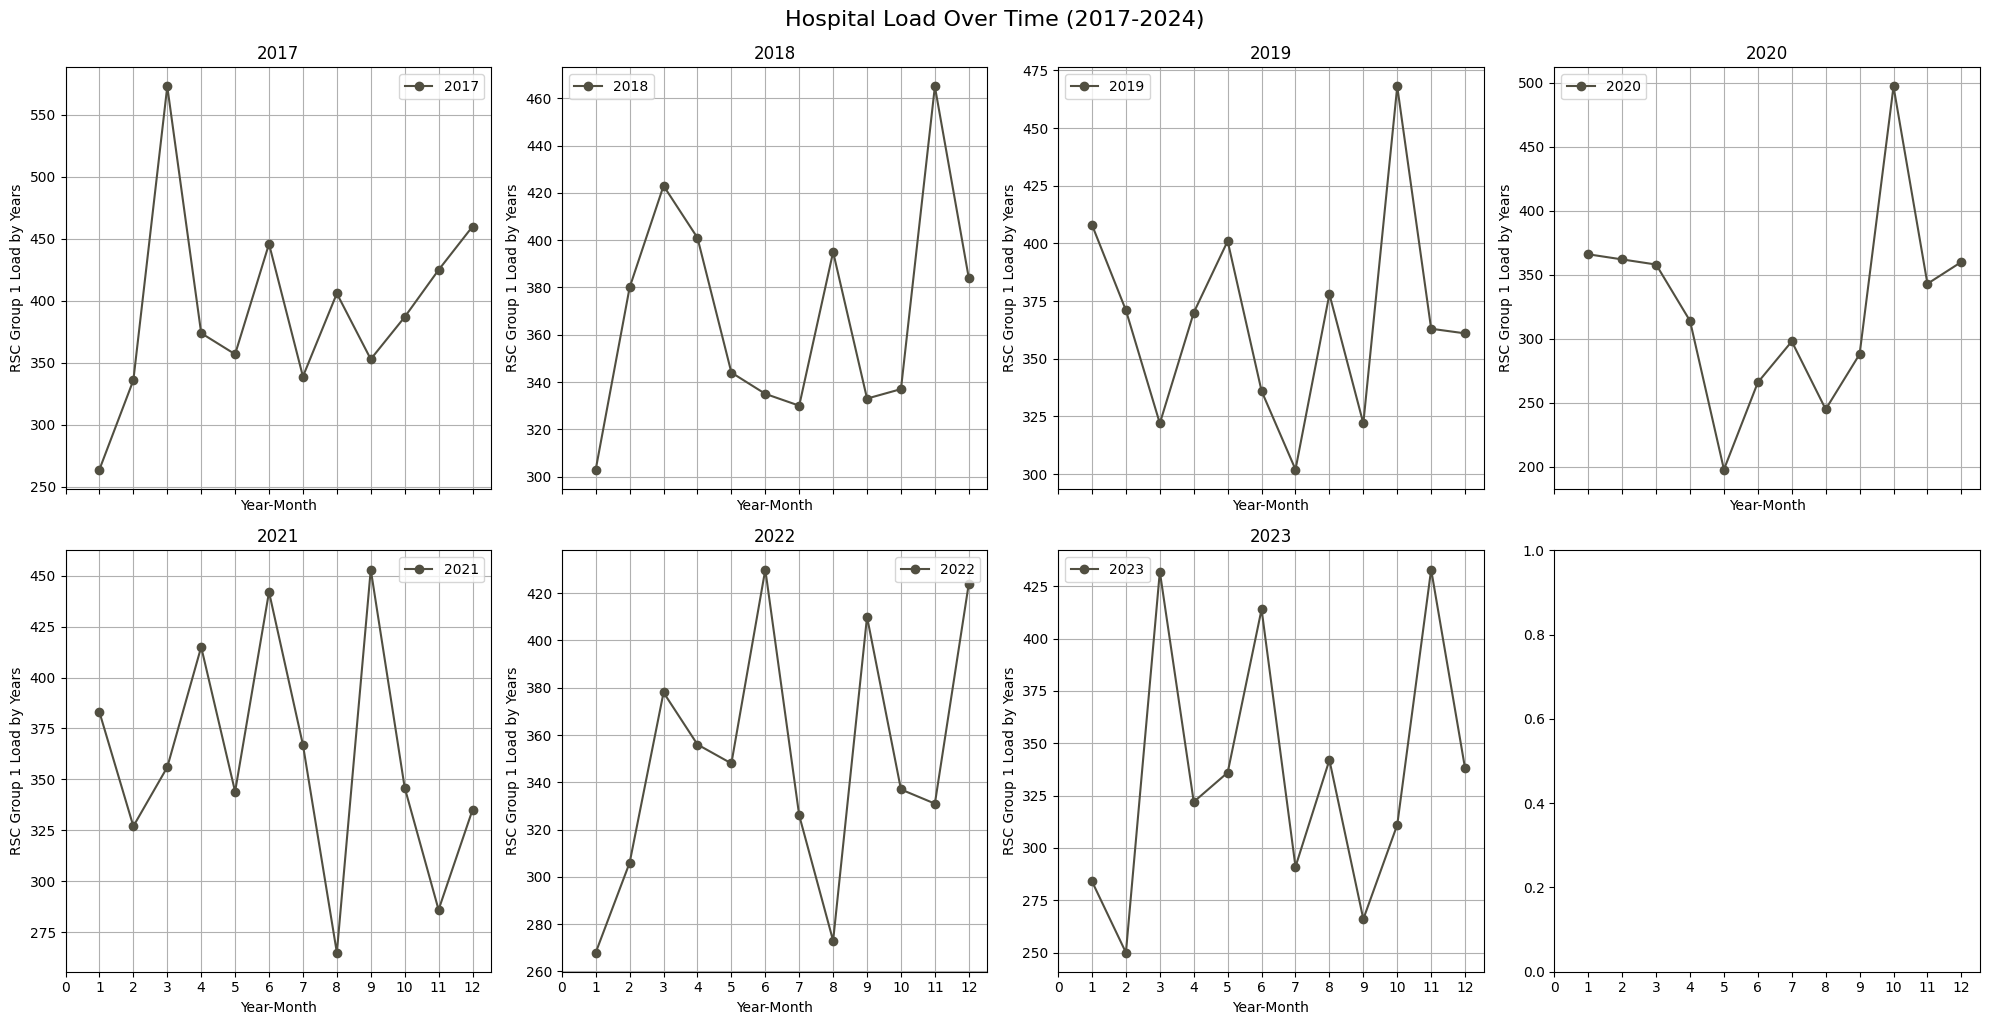

In [20]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10), sharex=True)
ax = ax.flatten()

for i, year in enumerate(data_rsc_train.year.unique()):
    data_plot = data_rsc_train.loc[data_rsc_train.year == year]
    ax[i].plot(data_plot['month'], data_plot["Пролечены_с_ОНМК_Всего"], 
             label=year, marker='o', color=palette["GVV_BSP_B2"])

    ax[i].set_title(year)
    ax[i].set_xlabel("Year-Month")
    ax[i].set_ylabel("RSC Group 1 Load by Years")
    ax[i].set_xticks(range(0, 13))
    ax[i].grid()
    ax[i].legend()

plt.tight_layout()
plt.suptitle("Hospital Load Over Time (2017-2024)", fontsize=16, y=1.02)
plt.show()

# ARIMA for sum of hospitals

## ACF & PACF

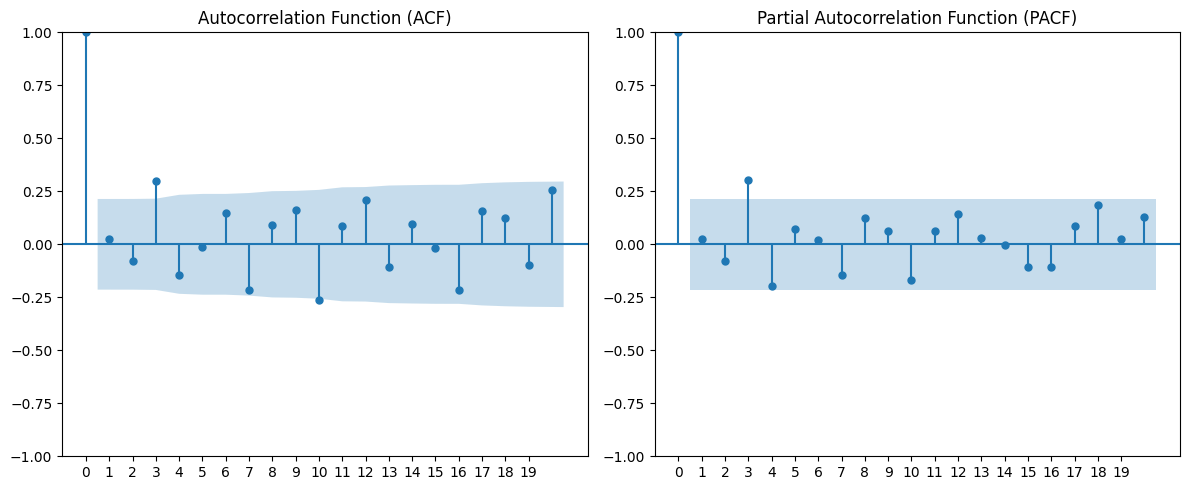

In [22]:
# Select the Load time series
load_series = data_rsc_train['Пролечены_с_ОНМК_Всего']

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF plot
plot_acf(load_series, ax=axes[0], lags=20)  # Adjust lags as needed
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xticks(range(0, 20))

# PACF plot
plot_pacf(load_series, ax=axes[1], lags=20, method='ywm')  # 'ywm' is robust for small samples
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xticks(range(0, 20))

plt.tight_layout()
plt.show()

## Model

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
# Select the Load time series
load_series = data_rsc_train['Пролечены_с_ОНМК_Всего']

# Model
model = ARIMA(load_series, order=(3, 0, 3))  # d=0 for stationary series
fitted_model = model.fit()

# Print summary of the model
print(fitted_model.summary())

# Forecast future values
forecast_steps = 12  # Number of periods to forecast
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(load_series.index[-1], periods=forecast_steps + 1, freq='M')[1:]
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

                                 SARIMAX Results                                  
Dep. Variable:     Пролечены_с_ОНМК_Всего   No. Observations:                   84
Model:                     ARIMA(3, 0, 3)   Log Likelihood                -452.860
Date:                    Thu, 19 Dec 2024   AIC                            921.720
Time:                            15:59:33   BIC                            941.166
Sample:                                 0   HQIC                           929.537
                                     - 84                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        356.8212     12.502     28.541      0.000     332.317     381.325
ar.L1         -0.2241      0.193     -1.161      0.246      -0.602       0.154
ar.L2          0.056

In [25]:
data_check_metrics = data_rsc[['Date', 'Date_Graph', 'Пролечены_с_ОНМК_Всего']].copy()
data_check_metrics.loc[:, "Prolecheno_Fitted"] = fitted_model.fittedvalues
data_check_metrics.loc[:, "Prolecheno_Prediction"] = pd.concat([pd.Series([None]*84), forecast_values])
data_check_metrics.loc[:, "Prolecheno_Prediction_CI_low"] = pd.concat([pd.Series([None]*84), forecast_ci['lower Пролечены_с_ОНМК_Всего']])
data_check_metrics.loc[:, "Prolecheno_Prediction_CI_upp"] = pd.concat([pd.Series([None]*84), forecast_ci['upper Пролечены_с_ОНМК_Всего']])

data_check_metrics = data_check_metrics.loc[data_check_metrics.Date <= pd.to_datetime("2024-10-10")]

### Forecast

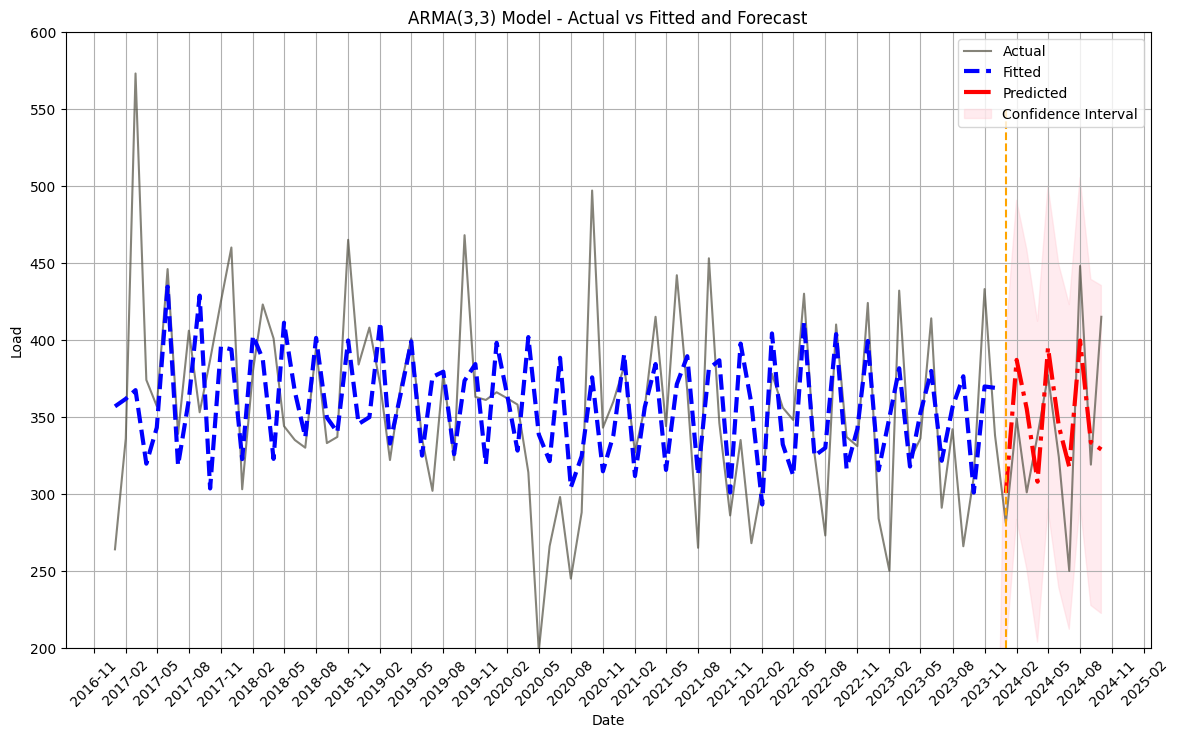

In [27]:
import matplotlib.dates as mdates

# Ensure Date_Graph is in datetime format
data_check_metrics['Date_Graph'] = pd.to_datetime(data_check_metrics['Date_Graph'], errors='coerce')

# Filter the dataset for plotting
tmp_data = data_check_metrics.fillna(0)

# Plot the data
plt.figure(figsize=(14, 8))
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Пролечены_с_ОНМК_Всего'], label='Actual', color=palette['GVV_BSP_B2'], alpha=0.7)
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Prolecheno_Fitted'], label='Fitted', color='blue', linestyle="dashed", linewidth=3)
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Prolecheno_Prediction'], label='Predicted', linestyle="dashdot", linewidth=3, color='red')
plt.vlines(x=pd.to_datetime("2024-01-01"), linestyles='--', color='orange', ymin=200, ymax=550)

#Add confidence intervals for predictions
plt.fill_between(tmp_data['Date_Graph'], 
                 tmp_data["Prolecheno_Prediction_CI_low"], 
                 tmp_data["Prolecheno_Prediction_CI_upp"], 
                 color='pink', alpha=0.3, label='Confidence Interval')

# Format x-axis ticks for every 2 months
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Major ticks every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as 'YYYY-MM'

# Rotate and align x-axis labels
plt.xticks(rotation=45)

# Add titles and labels
plt.title('ARMA(3,3) Model - Actual vs Fitted and Forecast')
plt.xlabel('Date')
plt.ylabel('Load')
plt.ylim(200, 600)
plt.legend()
plt.grid()
plt.show()

In [28]:
tmp_data = data_check_metrics.loc[data_check_metrics.Date_Graph > pd.to_datetime("2023-11-30")].fillna(190)
tmp_data.loc[tmp_data["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Prediction"] = data_check_metrics.loc[data_check_metrics["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Fitted"]

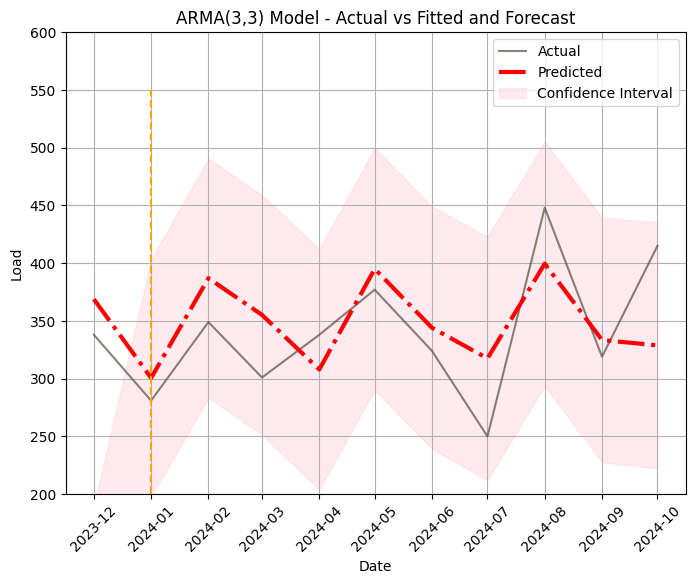

In [29]:
import matplotlib.dates as mdates

# Ensure Date_Graph is in datetime format
data_check_metrics['Date_Graph'] = pd.to_datetime(data_check_metrics['Date_Graph'], errors='coerce')

# Filter the dataset for plotting
tmp_data = data_check_metrics.loc[data_check_metrics.Date_Graph > pd.to_datetime("2023-11-30")].fillna(190)
tmp_data.loc[tmp_data["Date"] == pd.to_datetime("2023-12-01"), 
                "Prolecheno_Prediction"] = data_check_metrics.loc[data_check_metrics["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Fitted"]

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(tmp_data['Date_Graph'], tmp_data['Пролечены_с_ОНМК_Всего'], label='Actual', color=palette['GVV_BSP_B2'], alpha=0.7)
#plt.plot(tmp_data['Date_Graph'], tmp_data['Prolecheno_Fitted'], label='Fitted', color='blue', linestyle="dashed", linewidth=3)
plt.plot(tmp_data['Date_Graph'], tmp_data['Prolecheno_Prediction'], label='Predicted', linestyle="dashdot", linewidth=3, color='red')
plt.vlines(x=pd.to_datetime("2024-01-01"), linestyles='--', color='orange', ymin=200, ymax=550)

#Add confidence intervals for predictions
plt.fill_between(tmp_data['Date_Graph'], 
                 tmp_data["Prolecheno_Prediction_CI_low"].iloc[:], 
                 tmp_data["Prolecheno_Prediction_CI_upp"], 
                 color='pink', alpha=0.3, label='Confidence Interval')

# Format x-axis ticks for every 2 months
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as 'YYYY-MM'

# Rotate and align x-axis labels
plt.xticks(rotation=45)

# Add titles and labels
plt.title('ARMA(3,3) Model - Actual vs Fitted and Forecast')
plt.xlabel('Date')
plt.ylabel('Load')
plt.ylim(200, 600)
plt.legend()
plt.grid()
plt.show()

In [30]:
# Calculate metrics
mae = np.mean(np.abs(data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']))  # Mean Absolute Error
mse = np.mean((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']) ** 2)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mape = np.mean(np.abs((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']) / data_check_metrics['Пролечены_с_ОНМК_Всего'])) * 100  # Mean Absolute Percentage Error

# Print metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 39.66
MSE: 2093.70
RMSE: 45.76
MAPE: 11.89%


# One hospital

In [13]:
data_used.hosp_graph.unique()

array(['B15', 'B2', 'BSP', 'GVV'], dtype=object)

In [15]:
data_hosp = data_used.loc[data_used.hosp_graph == "BSP"]

## Seasonality

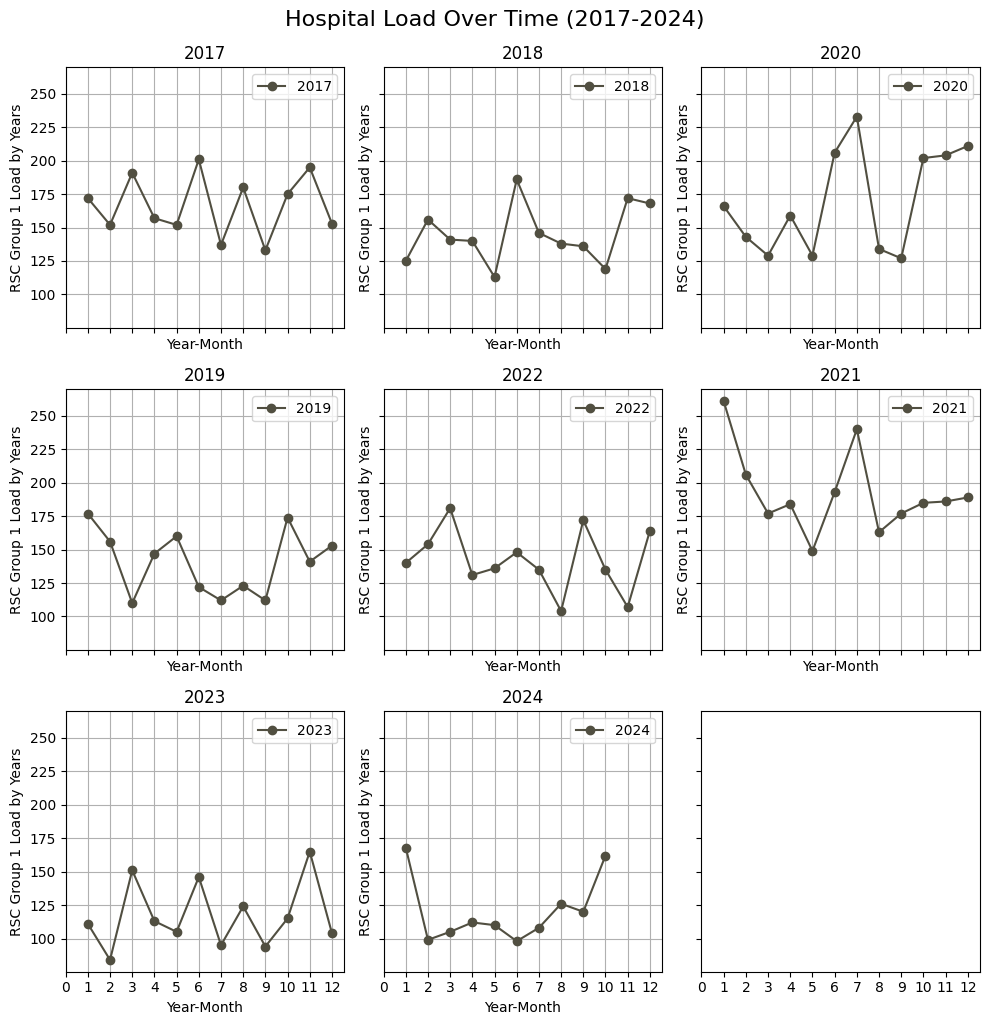

In [16]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
ax = ax.flatten()

for i, year in enumerate([2017, 2018, 2020, 2019, 2022, 2021, 2023, 2024]):
    data_plot = data_hosp.loc[data_hosp.year == year]
    ax[i].plot(data_plot['month'], data_plot["Пролечены_с_ОНМК_Всего"], 
             label=year, marker='o', color=palette["GVV_BSP_B2"])

    ax[i].set_title(year)
    ax[i].set_xlabel("Year-Month")
    ax[i].set_ylabel("RSC Group 1 Load by Years")
    ax[i].set_xticks(range(0, 13))
    ax[i].grid()
    ax[i].legend()

plt.tight_layout()
plt.suptitle("Hospital Load Over Time (2017-2024)", fontsize=16, y=1.02)
plt.show()

In [32]:
data_ts = data_hosp.loc[data_hosp.year.isin([2017, 2018, 2019, 2022, 2023])][['Пролечены_с_ОНМК_Всего', 'Date']]
data_ts = pd.Series(data_ts['Пролечены_с_ОНМК_Всего'])
data_ts.index = pd.date_range(start="2017-01-01", periods=60, freq="M")

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

Seasonal Strength: 0.191


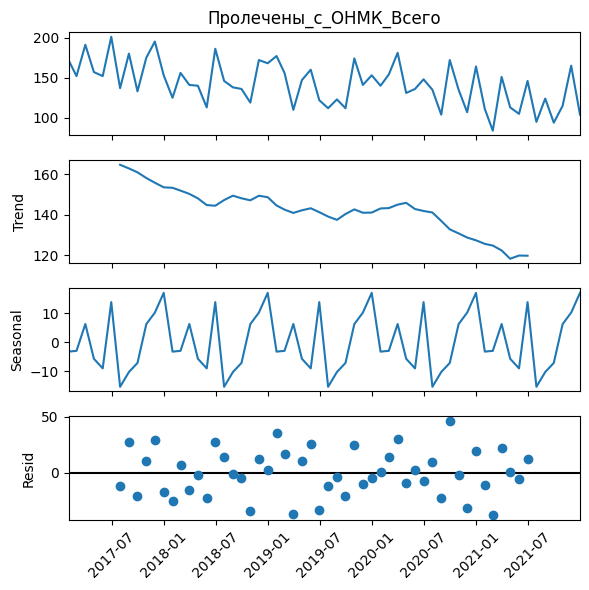

In [34]:
# Decompose the time series
decomposition = seasonal_decompose(data_ts, model='additive')
seasonal = decomposition.seasonal
residual = decomposition.resid

# Calculate variances
residual_variance = np.var(residual.dropna())
seasonal_variance = np.var(seasonal.dropna())

# Calculate Seasonal Strength
seasonal_strength = 1 - (residual_variance / (residual_variance + seasonal_variance))

print(f"Seasonal Strength: {seasonal_strength:.3f}")
fig = decomposition.plot()  # `decomposition.plot()` returns a Figure
fig.set_size_inches(6, 6)  # Optional: Adjust the figure size

# Rotate x-axis tick labels for each subplot
for ax in fig.axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## ARMA

### Training

In [20]:
data_model = data_hosp.loc[data_hosp.year.isin([2017, 2018, 2019, 2022, 2023, 2024])]

In [21]:
# Делим выборку на две части
data_model_train = data_model.loc[data_model.Date < pd.to_datetime("2024-01-01")]
data_model_test = data_model.loc[data_model.Date >= pd.to_datetime("2024-01-01")]

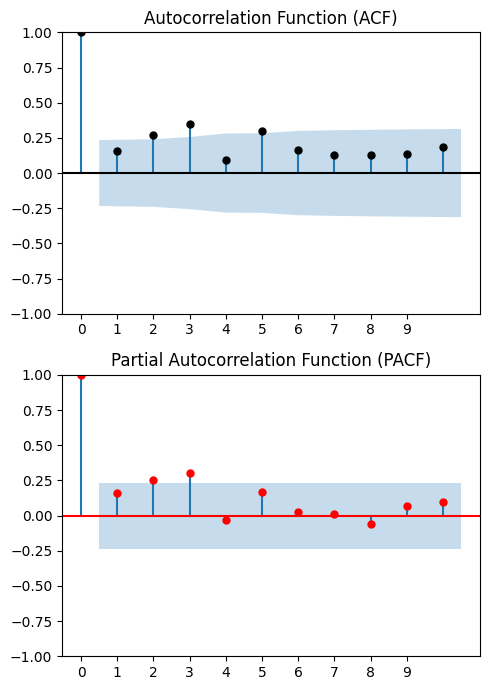

In [25]:
# Select the Load time series
load_series = data_model['Пролечены_с_ОНМК_Всего']

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(5, 7))

# ACF plot
plot_acf(load_series, ax=axes[0], lags=10, color="black")  # Adjust lags as needed
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xticks(range(0, 10))

# PACF plot
plot_pacf(load_series, ax=axes[1], lags=10, method='ywm', color='red')  # 'ywm' is robust for small samples
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xticks(range(0, 10))

plt.tight_layout()
plt.show()

In [26]:
# Select the Load time series
load_series = data_model_train['Пролечены_с_ОНМК_Всего']

# Model
model = ARIMA(load_series, order=(3, 0, 5))  # d=0 for stationary series
fitted_model = model.fit()

# Print summary of the model
print(fitted_model.summary())

# Forecast future values
forecast_steps = 10  # Number of periods to forecast
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(load_series.index[-1], periods=forecast_steps + 1, freq='M')[1:]
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

                                 SARIMAX Results                                  
Dep. Variable:     Пролечены_с_ОНМК_Всего   No. Observations:                   60
Model:                     ARIMA(3, 0, 5)   Log Likelihood                -275.334
Date:                    Fri, 20 Dec 2024   AIC                            570.669
Time:                            11:25:29   BIC                            591.612
Sample:                                 0   HQIC                           578.861
                                     - 60                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        142.4476     11.228     12.686      0.000     120.441     164.455
ar.L1         -0.6584      0.169     -3.887      0.000      -0.990      -0.326
ar.L2          0.417

In [27]:
data_check_metrics = data_model[['Date', 'Date_Graph', 'Пролечены_с_ОНМК_Всего']].copy()
data_check_metrics.loc[:, "Prolecheno_Fitted"] = fitted_model.fittedvalues

data_check_metrics = data_check_metrics.reset_index()
data_check_metrics.loc[:, "Prolecheno_Prediction"] = pd.concat([pd.Series([None]*60), forecast_values])
data_check_metrics.loc[:, "Prolecheno_Prediction_CI_low"] = pd.concat([pd.Series([None]*60), forecast_ci['lower Пролечены_с_ОНМК_Всего']])
data_check_metrics.loc[:, "Prolecheno_Prediction_CI_upp"] = pd.concat([pd.Series([None]*60), forecast_ci['upper Пролечены_с_ОНМК_Всего']])
data_check_metrics = data_check_metrics.loc[data_check_metrics.Date <= pd.to_datetime("2024-10-10")]

### Forecasting

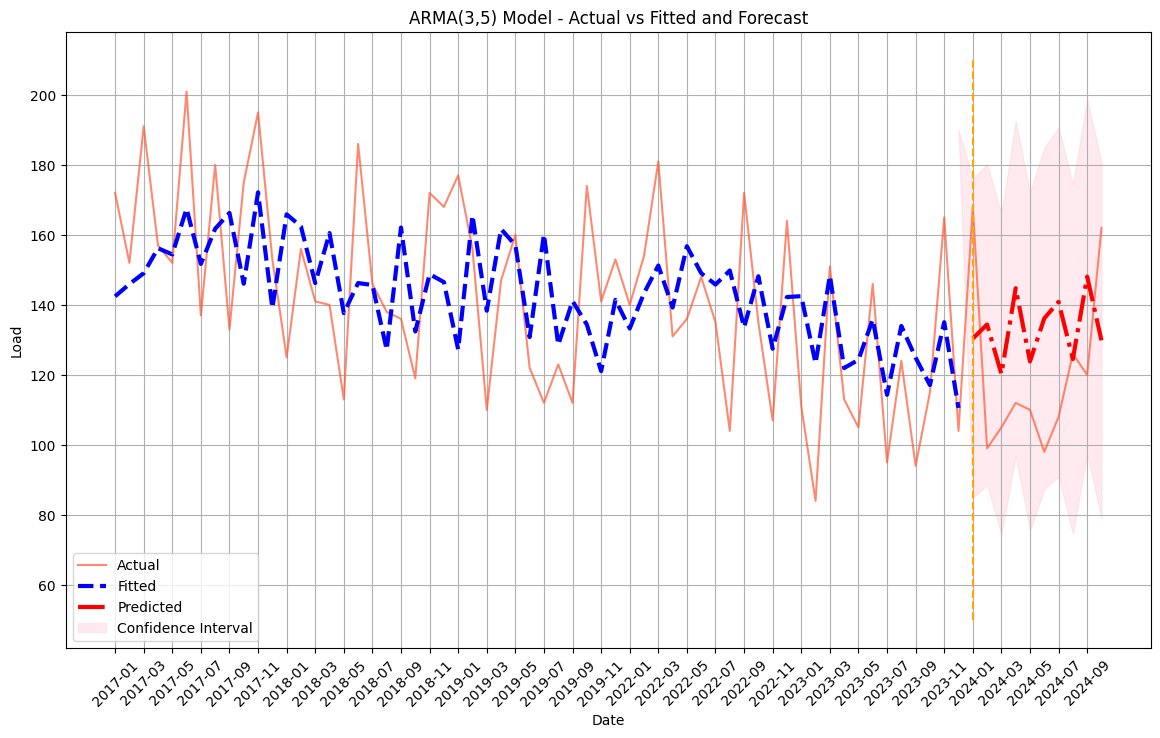

In [28]:
import matplotlib.dates as mdates

# Filter the dataset for plotting
tmp_data = data_check_metrics.fillna(0)
tmp_data = data_check_metrics.loc[data_check_metrics.Date > pd.to_datetime("2023-11-30")].fillna(190)
tmp_data.loc[tmp_data["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Prediction"] = data_check_metrics.loc[data_check_metrics["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Fitted"]

# Plot the data
plt.figure(figsize=(14, 8))
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Пролечены_с_ОНМК_Всего'], label='Actual', color=palette['BSP'], alpha=0.7)
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Prolecheno_Fitted'], label='Fitted', color='blue', linestyle="dashed", linewidth=3)
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Prolecheno_Prediction'], label='Predicted', linestyle="dashdot", linewidth=3, color='red')
plt.vlines(x="2024-01", linestyles='--', color='orange', ymin=50, ymax=210)

#Add confidence intervals for predictions
plt.fill_between(tmp_data['Date_Graph'], 
                 tmp_data["Prolecheno_Prediction_CI_low"], 
                 tmp_data["Prolecheno_Prediction_CI_upp"], 
                 color='pink', alpha=0.3, label='Confidence Interval')

# Xticks
xticks = data_check_metrics['Date_Graph'][::2]  # Select every second tick
xtick_labels = [tick for tick in xticks]  # Convert to string
plt.xticks(xticks, xtick_labels, rotation=45)

# Add titles and labels
plt.title('ARMA(3,5) Model - Actual vs Fitted and Forecast')
plt.xlabel('Date')
plt.ylabel('Load')
#plt.ylim(50, 230)
plt.legend()
plt.grid()
plt.show()

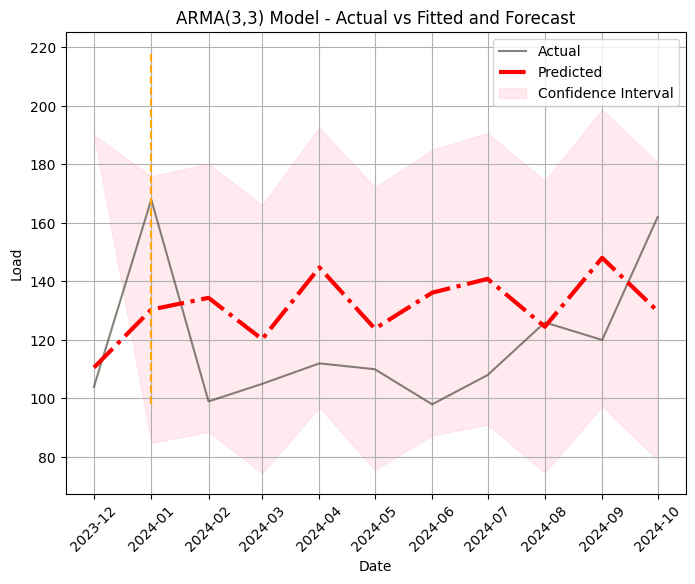

In [29]:
import matplotlib.dates as mdates

# Ensure Date_Graph is in datetime format
data_check_metrics['Date_Graph'] = pd.to_datetime(data_check_metrics['Date_Graph'], errors='coerce')

# Filter the dataset for plotting
tmp_data = data_check_metrics.loc[data_check_metrics.Date_Graph > pd.to_datetime("2023-11-30")].fillna(190)
tmp_data.loc[tmp_data["Date"] == pd.to_datetime("2023-12-01"), 
                "Prolecheno_Prediction"] = data_check_metrics.loc[data_check_metrics["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Fitted"]

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(tmp_data['Date_Graph'], tmp_data['Пролечены_с_ОНМК_Всего'], label='Actual', color=palette['GVV_BSP_B2'], alpha=0.7)
#plt.plot(tmp_data['Date_Graph'], tmp_data['Prolecheno_Fitted'], label='Fitted', color='blue', linestyle="dashed", linewidth=3)
plt.plot(tmp_data['Date_Graph'], tmp_data['Prolecheno_Prediction'], label='Predicted', linestyle="dashdot", linewidth=3, color='red')
plt.vlines(x=pd.to_datetime("2024-01-01"), linestyles='--', color='orange', ymin=tmp_data['Пролечены_с_ОНМК_Всего'].min(), ymax=tmp_data['Пролечены_с_ОНМК_Всего'].max()+50)

#Add confidence intervals for predictions
plt.fill_between(tmp_data['Date_Graph'], 
                 tmp_data["Prolecheno_Prediction_CI_low"].iloc[:], 
                 tmp_data["Prolecheno_Prediction_CI_upp"], 
                 color='pink', alpha=0.3, label='Confidence Interval')

# Format x-axis ticks for every 2 months
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as 'YYYY-MM'

# Rotate and align x-axis labels
plt.xticks(rotation=45)

# Add titles and labels
plt.title('ARMA(3,3) Model - Actual vs Fitted and Forecast')
plt.xlabel('Date')
plt.ylabel('Load')
#plt.ylim(50, 230)
plt.legend()
plt.grid()
plt.show()

In [31]:
# Calculate metrics - train
mae = np.mean(np.abs(data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Fitted']))  # Mean Absolute Error
mse = np.mean((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Fitted']) ** 2)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mape = np.mean(np.abs((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Fitted']) / data_check_metrics['Пролечены_с_ОНМК_Всего'])) * 100  # Mean Absolute Percentage Error

# Print metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 19.76
MSE: 568.04
RMSE: 23.83
MAPE: 14.50%


In [30]:
# Calculate metrics - test
mae = np.mean(np.abs(data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']))  # Mean Absolute Error
mse = np.mean((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']) ** 2)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mape = np.mean(np.abs((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']) / data_check_metrics['Пролечены_с_ОНМК_Всего'])) * 100  # Mean Absolute Percentage Error

# Print metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 26.76
MSE: 852.53
RMSE: 29.20
MAPE: 22.83%


## Prophet

In [323]:
# Делим выборку на две части
data_model_train = data_model.loc[data_model.Date < pd.to_datetime("2024-01-01")]
data_model_test = data_model.loc[data_model.Date >= pd.to_datetime("2024-01-01")]

17:33:38 - cmdstanpy - INFO - Chain [1] start processing
17:33:38 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 640x480 with 0 Axes>

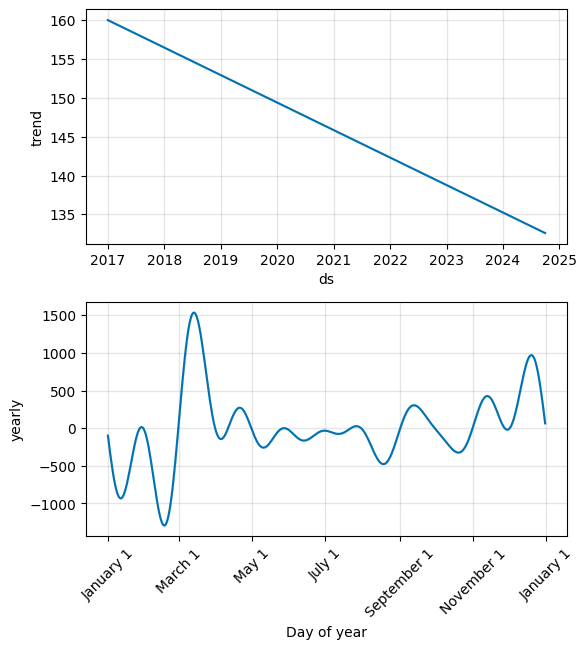

In [325]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Prepare the data for Prophet
# Ensure your DataFrame has 'Date' and 'Пролечены_с_ОНМК_Всего' columns
prophet_data = data_model_train[['Date', 'Пролечены_с_ОНМК_Всего']].rename(columns={'Date': 'ds', 'Пролечены_с_ОНМК_Всего': 'y'})

# Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(prophet_data)

# Create a DataFrame for future predictions (extend the time range if necessary)
future = model.make_future_dataframe(periods=10, freq='M')  # Forecast 12 months into the future
forecast = model.predict(future)

plt.tight_layout()
plt.show()

# Plot forecast components (trend, seasonality, etc.)
fig2 = model.plot_components(forecast, figsize=(6, 6))
plt.xticks(rotation=45)
plt.show()

### Forecasting

In [330]:
data_check_metrics = data_model[['Date', 'Date_Graph', 'Пролечены_с_ОНМК_Всего']].copy()
fitted = forecast.iloc[0:60]['yhat']
data_check_metrics['Prolecheno_Fitted'] = pd.concat([fitted, pd.Series([None]*10)]).values

# Add Predictions and Confidence Intervals
predicted = forecast.iloc[60:70]['yhat']
data_check_metrics['Prolecheno_Prediction'] = pd.concat([pd.Series([None]*60), predicted]).values

data_check_metrics['Prolecheno_Prediction_CI_low'] = forecast['yhat_lower'].values
    

data_check_metrics['Prolecheno_Prediction_CI_upp'] = forecast['yhat_upper'].values

# Display resulting DataFrame
data_check_metrics

,Date,Date_Graph,Пролечены_с_ОНМК_Всего,Prolecheno_Fitted,Prolecheno_Prediction,Prolecheno_Prediction_CI_low,Prolecheno_Prediction_CI_upp
1344,2017-01-01,2017-01,41.0,62.461593,None,35.322243,87.825943
1345,2017-02-01,2017-02,98.0,104.459169,None,76.477804,131.721806
1346,2017-03-01,2017-03,272.0,235.239775,None,208.217522,263.272023
1347,2017-04-01,2017-04,115.0,117.794558,None,90.719315,144.675265
1348,2017-05-01,2017-05,126.0,134.653495,None,108.962637,163.282892
...,...,...,...,...,...,...,...
1433,2024-06-01,2024-06,141.0,None,115.436819,89.049130,142.460151
1434,2024-07-01,2024-07,119.0,None,101.69166,71.373247,129.636615
1435,2024-08-01,2024-08,149.0,None,127.514309,99.583347,155.660005
1436,2024-09-01,2024-09,117.0,None,79.378358,52.146656,105.499259


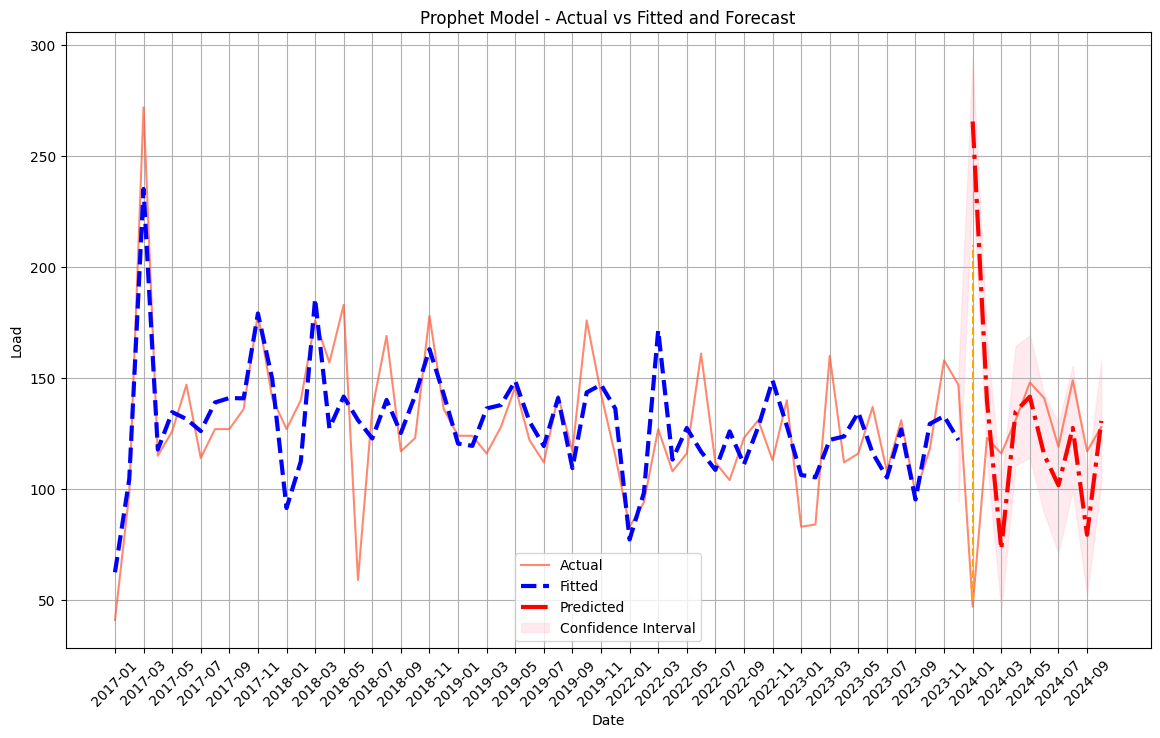

In [331]:
import matplotlib.dates as mdates

# Filter the dataset for plotting
tmp_data = data_check_metrics.fillna(0)
tmp_data = data_check_metrics.loc[data_check_metrics.Date > pd.to_datetime("2023-11-30")].fillna(190)
tmp_data.loc[tmp_data["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Prediction"] = data_check_metrics.loc[data_check_metrics["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Fitted"]

# Plot the data
plt.figure(figsize=(14, 8))
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Пролечены_с_ОНМК_Всего'], label='Actual', color=palette['BSP'], alpha=0.7)
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Prolecheno_Fitted'], label='Fitted', color='blue', linestyle="dashed", linewidth=3)
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Prolecheno_Prediction'], label='Predicted', linestyle="dashdot", linewidth=3, color='red')
plt.vlines(x="2024-01", linestyles='--', color='orange', ymin=50, ymax=210)

#Add confidence intervals for predictions
plt.fill_between(tmp_data['Date_Graph'], 
                 tmp_data["Prolecheno_Prediction_CI_low"], 
                 tmp_data["Prolecheno_Prediction_CI_upp"], 
                 color='pink', alpha=0.3, label='Confidence Interval')

# Xticks
xticks = data_check_metrics['Date_Graph'][::2]  # Select every second tick
xtick_labels = [tick for tick in xticks]  # Convert to string
plt.xticks(xticks, xtick_labels, rotation=45)

# Add titles and labels
plt.title('Prophet Model - Actual vs Fitted and Forecast')
plt.xlabel('Date')
plt.ylabel('Load')
#plt.ylim(50, 230)
plt.legend()
plt.grid()
plt.show()

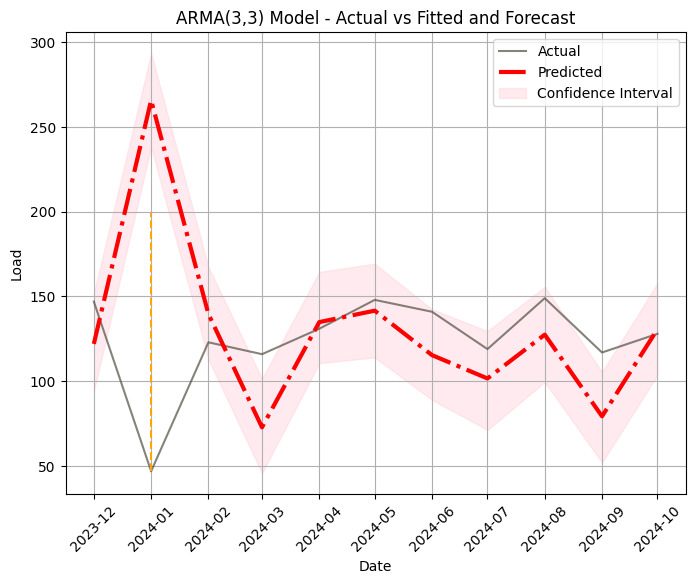

In [328]:
import matplotlib.dates as mdates

# Ensure Date_Graph is in datetime format
data_check_metrics['Date_Graph'] = pd.to_datetime(data_check_metrics['Date_Graph'], errors='coerce')

# Filter the dataset for plotting
tmp_data = data_check_metrics.loc[data_check_metrics.Date_Graph > pd.to_datetime("2023-11-30")].fillna(190)
tmp_data.loc[tmp_data["Date"] == pd.to_datetime("2023-12-01"), 
                "Prolecheno_Prediction"] = data_check_metrics.loc[data_check_metrics["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Fitted"]

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(tmp_data['Date_Graph'], tmp_data['Пролечены_с_ОНМК_Всего'], label='Actual', color=palette['GVV_BSP_B2'], alpha=0.7)
#plt.plot(tmp_data['Date_Graph'], tmp_data['Prolecheno_Fitted'], label='Fitted', color='blue', linestyle="dashed", linewidth=3)
plt.plot(tmp_data['Date_Graph'], tmp_data['Prolecheno_Prediction'], label='Predicted', linestyle="dashdot", linewidth=3, color='red')
plt.vlines(x=pd.to_datetime("2024-01-01"), linestyles='--', color='orange', ymin=tmp_data['Пролечены_с_ОНМК_Всего'].min(), ymax=tmp_data['Пролечены_с_ОНМК_Всего'].max()+50)

#Add confidence intervals for predictions
plt.fill_between(tmp_data['Date_Graph'], 
                 tmp_data["Prolecheno_Prediction_CI_low"].iloc[:], 
                 tmp_data["Prolecheno_Prediction_CI_upp"], 
                 color='pink', alpha=0.3, label='Confidence Interval')

# Format x-axis ticks for every 2 months
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as 'YYYY-MM'

# Rotate and align x-axis labels
plt.xticks(rotation=45)

# Add titles and labels
plt.title('ARMA(3,3) Model - Actual vs Fitted and Forecast')
plt.xlabel('Date')
plt.ylabel('Load')
#plt.ylim(50, 230)
plt.legend()
plt.grid()
plt.show()

In [302]:
# Calculate metrics
mae = np.mean(np.abs(data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']))  # Mean Absolute Error
mse = np.mean((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']) ** 2)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mape = np.mean(np.abs((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']) / data_check_metrics['Пролечены_с_ОНМК_Всего'])) * 100  # Mean Absolute Percentage Error

# Print metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 39.35
MSE: 5284.66
RMSE: 72.70
MAPE: 60.47%


# All hospital together

In [42]:
data_used.hosp_graph.unique()

array(['B15', 'B2', 'BSP', 'GVV'], dtype=object)

In [43]:
data_hosp = data_used.copy()
data_hosp = data_hosp.groupby(['Date', 'Date_Graph', 'year', 'month']).sum().reset_index()

## Seasonality

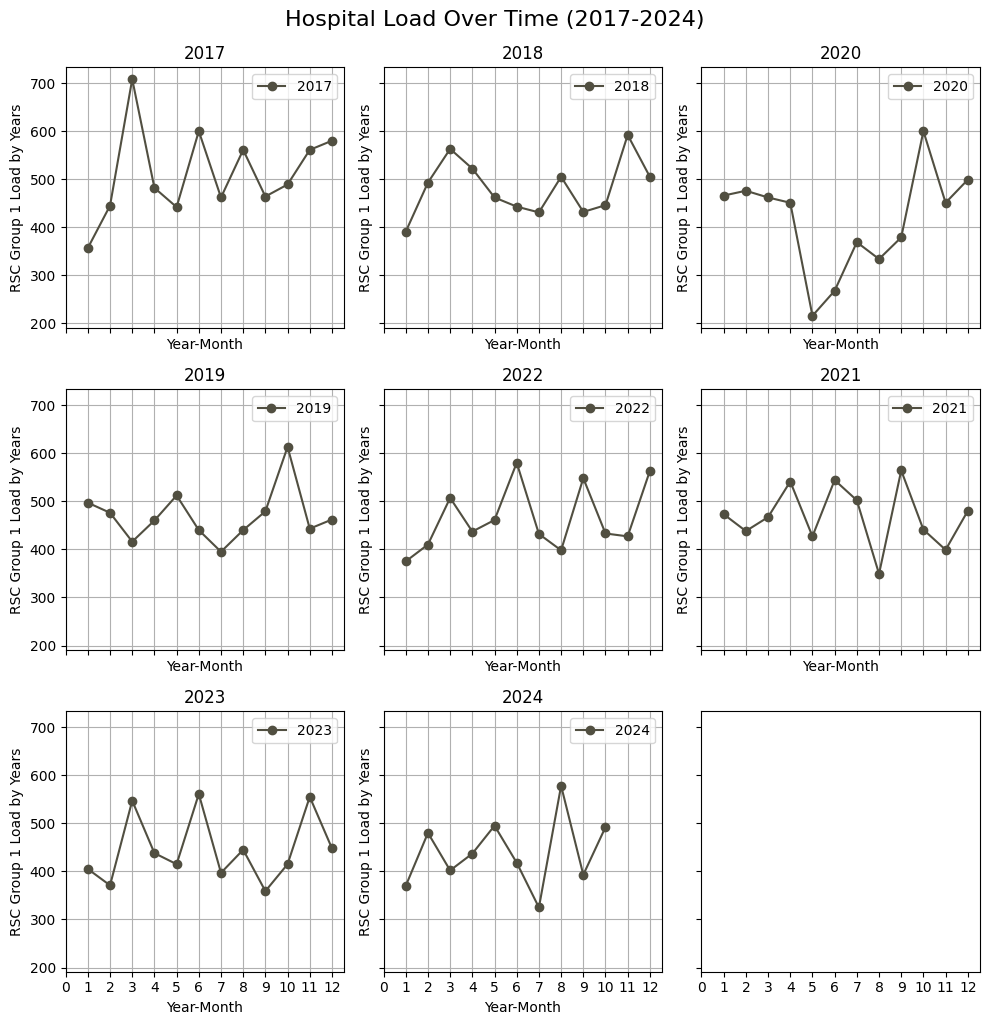

In [44]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
ax = ax.flatten()

for i, year in enumerate([2017, 2018, 2020, 2019, 2022, 2021, 2023, 2024]):
    data_plot = data_hosp.loc[data_hosp.year == year]
    ax[i].plot(data_plot['month'], data_plot["Пролечены_с_ОНМК_Всего"], 
             label=year, marker='o', color=palette["GVV_BSP_B2"])

    ax[i].set_title(year)
    ax[i].set_xlabel("Year-Month")
    ax[i].set_ylabel("RSC Group 1 Load by Years")
    ax[i].set_xticks(range(0, 13))
    ax[i].grid()
    ax[i].legend()

plt.tight_layout()
plt.suptitle("Hospital Load Over Time (2017-2024)", fontsize=16, y=1.02)
plt.show()

In [45]:
data_ts = data_hosp.loc[data_hosp.year.isin([2017, 2018, 2019, 2022, 2023])][['Пролечены_с_ОНМК_Всего', 'Date']]
data_ts = pd.Series(data_ts['Пролечены_с_ОНМК_Всего'])
data_ts.index = pd.date_range(start="2017-01-01", periods=60, freq="M")

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

Seasonal Strength: 0.318


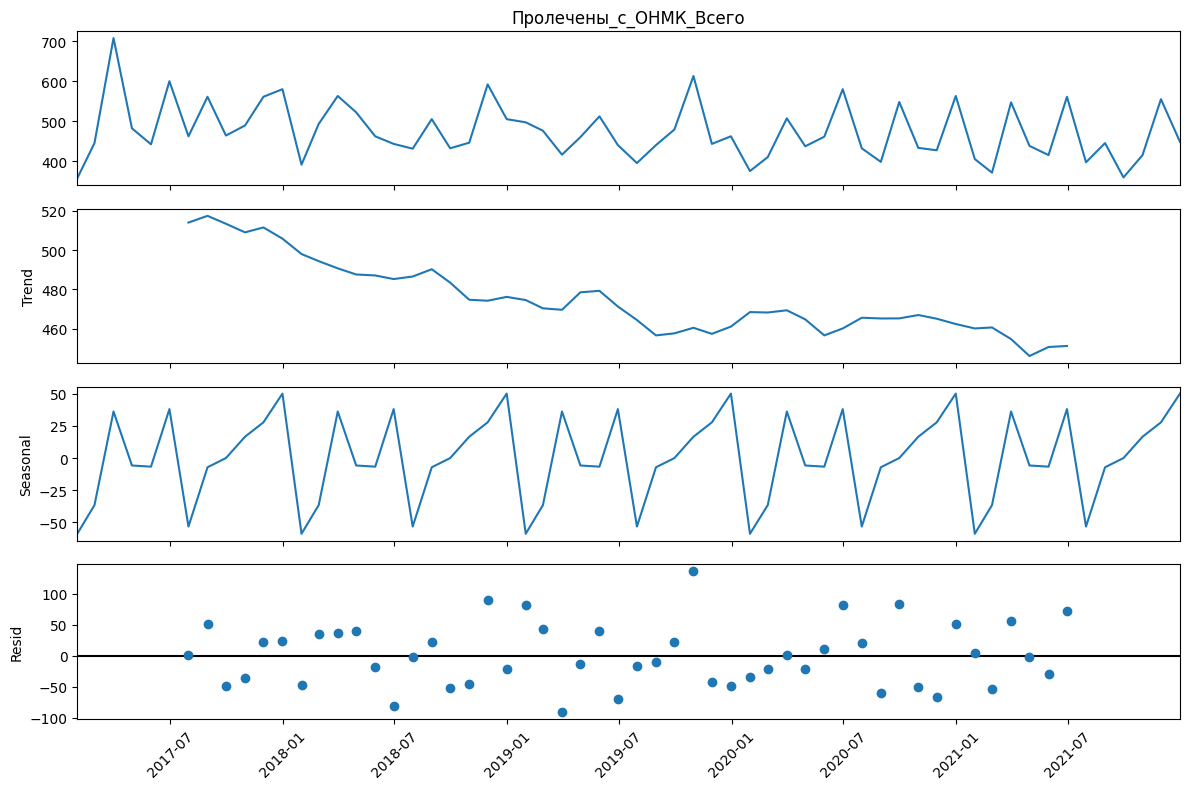

In [47]:
# Decompose the time series
decomposition = seasonal_decompose(data_ts, model='additive')
seasonal = decomposition.seasonal
residual = decomposition.resid

# Calculate variances
residual_variance = np.var(residual.dropna())
seasonal_variance = np.var(seasonal.dropna())

# Calculate Seasonal Strength
seasonal_strength = 1 - (residual_variance / (residual_variance + seasonal_variance))

print(f"Seasonal Strength: {seasonal_strength:.3f}")
fig = decomposition.plot()  # `decomposition.plot()` returns a Figure
fig.set_size_inches(12, 8)  # Optional: Adjust the figure size

# Rotate x-axis tick labels for each subplot
for ax in fig.axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [48]:
data_plot = data_hosp.copy()
data_plot.set_index('Date', inplace=True)
data_plot = data_plot.dropna().fillna(0)

# Perform the Dickey-Fuller test
result = adfuller(data_plot['Пролечены_с_ОНМК_Всего'])

# Display results
print("Dickey-Fuller Test Results:")
print(f"Test Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Number of Lags Used: {result[2]}")
print(f"Number of Observations Used: {result[3]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

Dickey-Fuller Test Results:
Test Statistic: -3.9283437100459144
p-value: 0.0018358773079527196
Number of Lags Used: 6
Number of Observations Used: 87
Critical Values:
   1%: -3.5078527246648834
   5%: -2.895382030636155
   10%: -2.584823877658872


## ARMA

### Training

In [72]:
data_model = data_hosp.loc[data_hosp.year.isin([2017, 2018, 2019, 2022, 2023, 2024])]

In [73]:
# Делим выборку на две части
data_model_train = data_model.loc[data_model.Date < pd.to_datetime("2024-01-01")]
data_model_test = data_model.loc[data_model.Date >= pd.to_datetime("2024-01-01")]

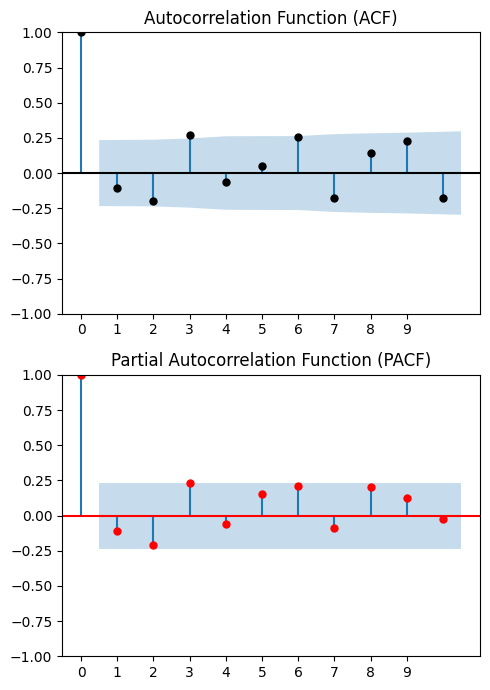

In [74]:
# Select the Load time series
load_series = data_model['Пролечены_с_ОНМК_Всего']

# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(5, 7))

# ACF plot
plot_acf(load_series, ax=axes[0], lags=10, color="black")  # Adjust lags as needed
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xticks(range(0, 10))

# PACF plot
plot_pacf(load_series, ax=axes[1], lags=10, method='ywm', color='red')  # 'ywm' is robust for small samples
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xticks(range(0, 10))

plt.tight_layout()
plt.show()

In [77]:
# Select the Load time series
load_series = data_model_train['Пролечены_с_ОНМК_Всего']

# Model
model = ARIMA(load_series, order=(3, 0, 3))  # d=0 for stationary series
fitted_model = model.fit()

# Print summary of the model
print(fitted_model.summary())

# Forecast future values
forecast_steps = 10  # Number of periods to forecast
forecast = fitted_model.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(load_series.index[-1], periods=forecast_steps + 1, freq='M')[1:]
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

                                 SARIMAX Results                                  
Dep. Variable:     Пролечены_с_ОНМК_Всего   No. Observations:                   60
Model:                     ARIMA(3, 0, 3)   Log Likelihood                -332.996
Date:                    Fri, 20 Dec 2024   AIC                            681.991
Time:                            12:37:20   BIC                            698.746
Sample:                                 0   HQIC                           688.545
                                     - 60                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        474.9660     14.997     31.670      0.000     445.572     504.360
ar.L1         -0.2159      0.281     -0.769      0.442      -0.766       0.335
ar.L2          0.198

In [89]:
data_check_metrics = data_model[['Date', 'Date_Graph', 'Пролечены_с_ОНМК_Всего']].copy()
data_check_metrics.loc[:, "Prolecheno_Fitted"] = fitted_model.fittedvalues

data_check_metrics = data_check_metrics.reset_index()
data_check_metrics.loc[:, "Prolecheno_Prediction"] = pd.concat([pd.Series([None]*60), forecast_values])
data_check_metrics.loc[:, "Prolecheno_Prediction_CI_low"] = pd.concat([pd.Series([None]*60), forecast_ci['lower Пролечены_с_ОНМК_Всего']])
data_check_metrics.loc[:, "Prolecheno_Prediction_CI_upp"] = pd.concat([pd.Series([None]*60), forecast_ci['upper Пролечены_с_ОНМК_Всего']])
data_check_metrics = data_check_metrics.loc[data_check_metrics.Date <= pd.to_datetime("2024-10-10")]

### Forecasting

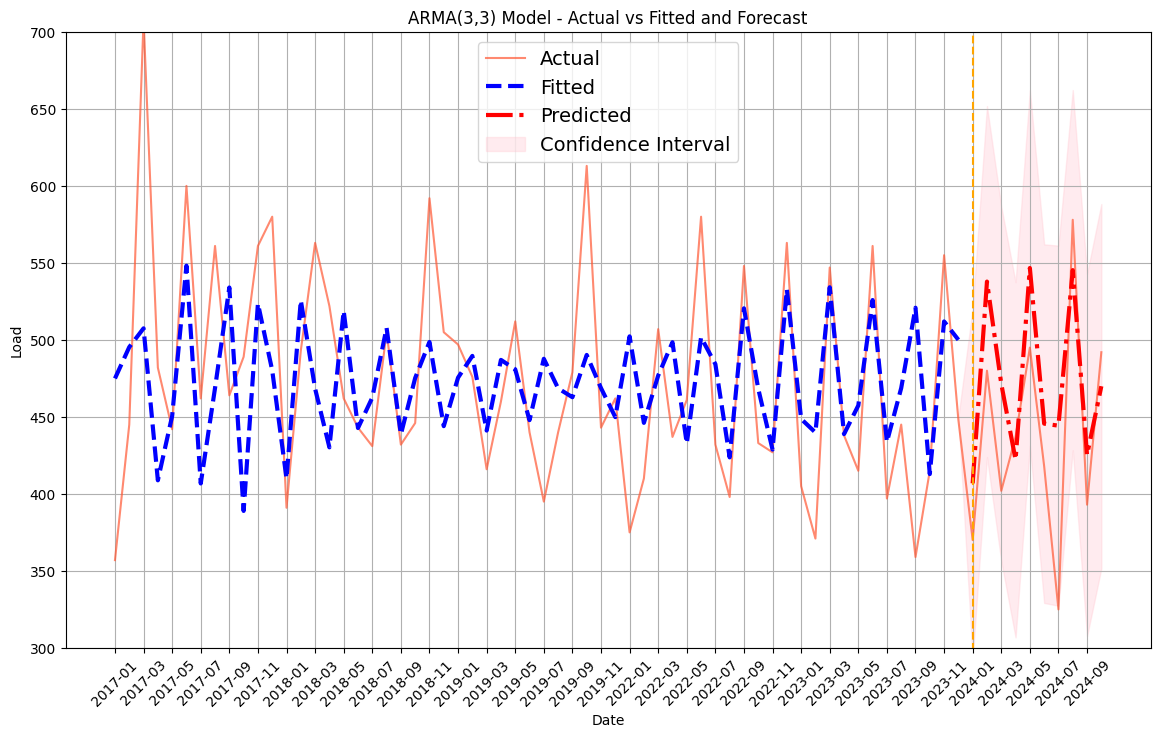

In [90]:
import matplotlib.dates as mdates

# Filter the dataset for plotting
tmp_data = data_check_metrics.fillna(0)
tmp_data = data_check_metrics.loc[data_check_metrics.Date > pd.to_datetime("2023-11-30")].fillna(450)
tmp_data.loc[tmp_data["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Prediction"] = data_check_metrics.loc[data_check_metrics["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Fitted"]

# Plot the data
plt.figure(figsize=(14, 8))
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Пролечены_с_ОНМК_Всего'], label='Actual', color=palette['BSP'], alpha=0.7)
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Prolecheno_Fitted'], label='Fitted', color='blue', linestyle="dashed", linewidth=3)
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Prolecheno_Prediction'], label='Predicted', linestyle="dashdot", linewidth=3, color='red')
plt.vlines(x="2024-01", linestyles='--', 
           color='orange', ymin=200, ymax=700)

#Add confidence intervals for predictions
plt.fill_between(tmp_data['Date_Graph'], 
                 tmp_data["Prolecheno_Prediction_CI_low"], 
                 tmp_data["Prolecheno_Prediction_CI_upp"], 
                 color='pink', alpha=0.3, label='Confidence Interval')

# Xticks
xticks = data_check_metrics['Date_Graph'][::2]  # Select every second tick
xtick_labels = [tick for tick in xticks]  # Convert to string
plt.xticks(xticks, xtick_labels, rotation=45)

# Add titles and labels
plt.title('ARMA(3,3) Model - Actual vs Fitted and Forecast')
plt.xlabel('Date')
plt.ylabel('Load')
plt.ylim(300, 700)
plt.legend(fontsize=14)
plt.grid()
plt.show()

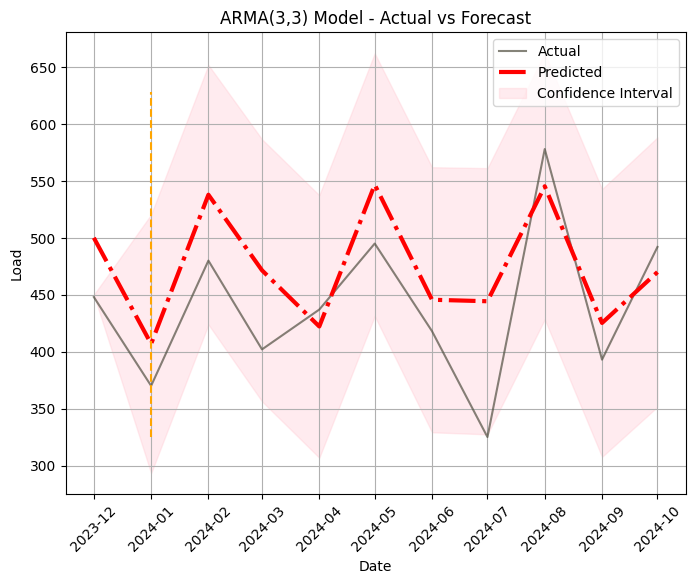

In [91]:
import matplotlib.dates as mdates

# Ensure Date_Graph is in datetime format
data_check_metrics['Date_Graph'] = pd.to_datetime(data_check_metrics['Date_Graph'], errors='coerce')

# Filter the dataset for plotting
tmp_data = data_check_metrics.loc[data_check_metrics.Date_Graph > pd.to_datetime("2023-11-30")].fillna(450)
tmp_data.loc[tmp_data["Date"] == pd.to_datetime("2023-12-01"), 
                "Prolecheno_Prediction"] = data_check_metrics.loc[data_check_metrics["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Fitted"]

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(tmp_data['Date_Graph'], tmp_data['Пролечены_с_ОНМК_Всего'], label='Actual', color=palette['GVV_BSP_B2'], alpha=0.7)
#plt.plot(tmp_data['Date_Graph'], tmp_data['Prolecheno_Fitted'], label='Fitted', color='blue', linestyle="dashed", linewidth=3)
plt.plot(tmp_data['Date_Graph'], tmp_data['Prolecheno_Prediction'], label='Predicted', linestyle="dashdot", linewidth=3, color='red')
plt.vlines(x=pd.to_datetime("2024-01-01"), linestyles='--', color='orange', ymin=tmp_data['Пролечены_с_ОНМК_Всего'].min(), ymax=tmp_data['Пролечены_с_ОНМК_Всего'].max()+50)

#Add confidence intervals for predictions
plt.fill_between(tmp_data['Date_Graph'], 
                 tmp_data["Prolecheno_Prediction_CI_low"].iloc[:], 
                 tmp_data["Prolecheno_Prediction_CI_upp"], 
                 color='pink', alpha=0.3, label='Confidence Interval')

# Format x-axis ticks for every 2 months
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as 'YYYY-MM'

# Rotate and align x-axis labels
plt.xticks(rotation=45)

# Add titles and labels
plt.title('ARMA(3,3) Model - Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Load')
#plt.ylim(50, 230)
plt.legend()
plt.grid()
plt.show()

In [64]:
# Calculate metrics - train
mae = np.mean(np.abs(data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Fitted']))  # Mean Absolute Error
mse = np.mean((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Fitted']) ** 2)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mape = np.mean(np.abs((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Fitted']) / data_check_metrics['Пролечены_с_ОНМК_Всего'])) * 100  # Mean Absolute Percentage Error

# Print metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 49.32
MSE: 4092.49
RMSE: 63.97
MAPE: 10.42%


In [65]:
# Calculate metrics
mae = np.mean(np.abs(data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']))  # Mean Absolute Error
mse = np.mean((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']) ** 2)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mape = np.mean(np.abs((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']) / data_check_metrics['Пролечены_с_ОНМК_Всего'])) * 100  # Mean Absolute Percentage Error

# Print metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 46.46
MSE: 3001.28
RMSE: 54.78
MAPE: 11.48%


## Prophet

In [404]:
# Делим выборку на две части
data_model_train = data_model.loc[data_model.Date < pd.to_datetime("2024-01-01")]
data_model_test = data_model.loc[data_model.Date >= pd.to_datetime("2024-01-01")]

17:49:10 - cmdstanpy - INFO - Chain [1] start processing
17:49:11 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 640x480 with 0 Axes>

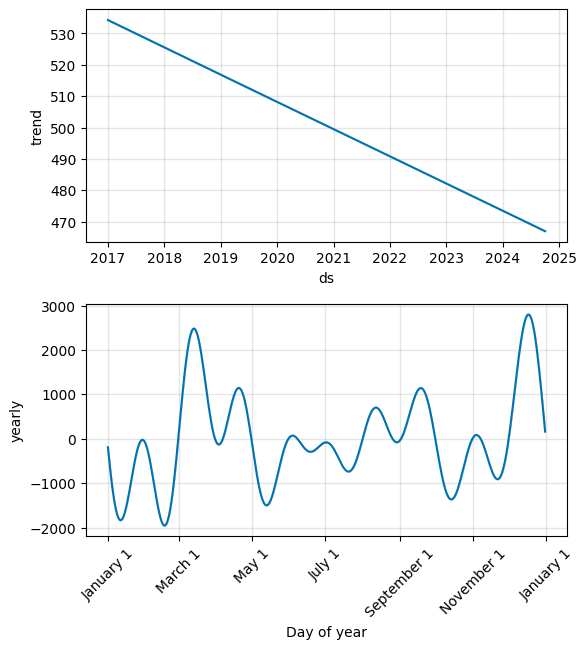

In [405]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Prepare the data for Prophet
# Ensure your DataFrame has 'Date' and 'Пролечены_с_ОНМК_Всего' columns
prophet_data = data_model_train[['Date', 'Пролечены_с_ОНМК_Всего']].rename(columns={'Date': 'ds', 'Пролечены_с_ОНМК_Всего': 'y'})

# Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(prophet_data)

# Create a DataFrame for future predictions (extend the time range if necessary)
future = model.make_future_dataframe(periods=data_model_test.shape[0], freq='MS')  # Forecast 12 months into the future
forecast = model.predict(future)

plt.tight_layout()
plt.show()

# Plot forecast components (trend, seasonality, etc.)
fig2 = model.plot_components(forecast, figsize=(6, 6))
plt.xticks(rotation=45)
plt.show()

### Forecasting

In [407]:
data_check_metrics = data_model[['Date', 'Date_Graph', 'Пролечены_с_ОНМК_Всего']].copy()
data_check_metrics = data_check_metrics.reset_index()

train_size = data_model_train.shape[0]
test_size = data_model_test.shape[0]

fitted = forecast.iloc[0:train_size]['yhat']
data_check_metrics['Prolecheno_Fitted'] = pd.concat([fitted, pd.Series([None]*test_size)]).values

# Add Predictions and Confidence Intervals
predicted = forecast.iloc[train_size:70]['yhat']
data_check_metrics['Prolecheno_Prediction'] = pd.concat([pd.Series([None]*train_size), predicted]).values

data_check_metrics['Prolecheno_Prediction_CI_low'] = forecast['yhat_lower'].values
    

data_check_metrics['Prolecheno_Prediction_CI_upp'] = forecast['yhat_upper'].values

# Display resulting DataFrame
data_check_metrics

,index,Date,Date_Graph,Пролечены_с_ОНМК_Всего,Prolecheno_Fitted,Prolecheno_Prediction,Prolecheno_Prediction_CI_low,Prolecheno_Prediction_CI_upp
0,0,2017-01-01,2017-01,357.0,346.064189,None,282.878570,403.774220
1,1,2017-02-01,2017-02,445.0,447.436803,None,386.248766,509.773191
2,2,2017-03-01,2017-03,708.0,659.441046,None,598.059069,718.282586
3,3,2017-04-01,2017-04,482.0,472.562795,None,412.233354,534.467203
4,4,2017-05-01,2017-05,442.0,427.972273,None,368.601023,491.088523
...,...,...,...,...,...,...,...,...
65,89,2024-06-01,2024-06,418.0,None,506.893579,448.123121,566.334917
66,90,2024-07-01,2024-07,325.0,None,389.825971,328.125467,446.682928
67,91,2024-08-01,2024-08,578.0,None,489.035977,427.220345,548.439871
68,92,2024-09-01,2024-09,393.0,None,437.564163,381.683041,494.291632


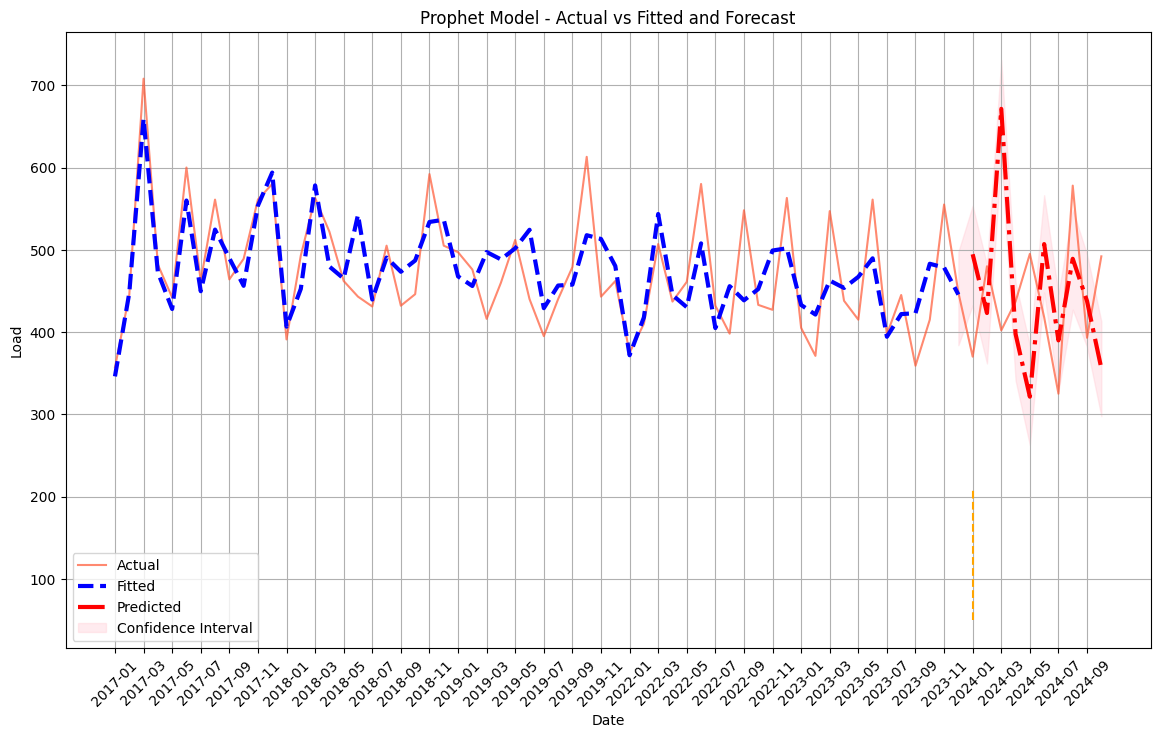

In [408]:
import matplotlib.dates as mdates

# Filter the dataset for plotting
tmp_data = data_check_metrics.fillna(0)
tmp_data = data_check_metrics.loc[data_check_metrics.Date > pd.to_datetime("2023-11-30")].fillna(190)
tmp_data.loc[tmp_data["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Prediction"] = data_check_metrics.loc[data_check_metrics["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Fitted"]

# Plot the data
plt.figure(figsize=(14, 8))
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Пролечены_с_ОНМК_Всего'], label='Actual', color=palette['BSP'], alpha=0.7)
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Prolecheno_Fitted'], label='Fitted', color='blue', linestyle="dashed", linewidth=3)
plt.plot(data_check_metrics['Date_Graph'], data_check_metrics['Prolecheno_Prediction'], label='Predicted', linestyle="dashdot", linewidth=3, color='red')
plt.vlines(x="2024-01", linestyles='--', color='orange', ymin=50, ymax=210)

#Add confidence intervals for predictions
plt.fill_between(tmp_data['Date_Graph'], 
                 tmp_data["Prolecheno_Prediction_CI_low"], 
                 tmp_data["Prolecheno_Prediction_CI_upp"], 
                 color='pink', alpha=0.3, label='Confidence Interval')

# Xticks
xticks = data_check_metrics['Date_Graph'][::2]  # Select every second tick
xtick_labels = [tick for tick in xticks]  # Convert to string
plt.xticks(xticks, xtick_labels, rotation=45)

# Add titles and labels
plt.title('Prophet Model - Actual vs Fitted and Forecast')
plt.xlabel('Date')
plt.ylabel('Load')
#plt.ylim(50, 230)
plt.legend()
plt.grid()
plt.show()

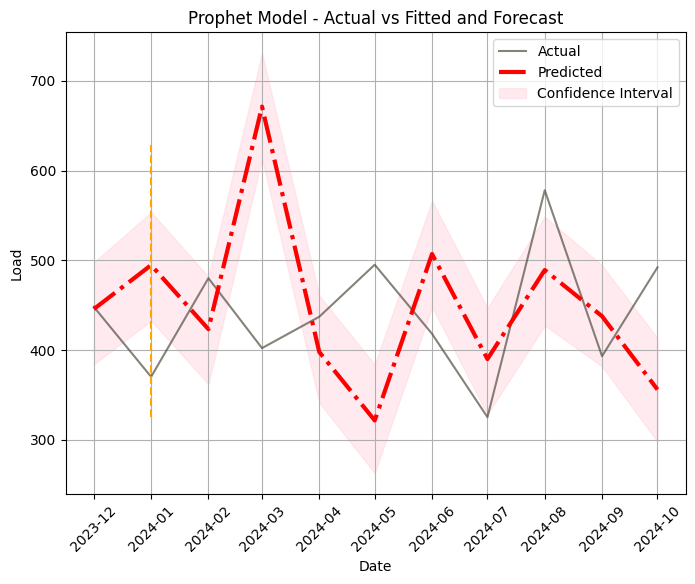

In [409]:
import matplotlib.dates as mdates

# Ensure Date_Graph is in datetime format
data_check_metrics['Date_Graph'] = pd.to_datetime(data_check_metrics['Date_Graph'], errors='coerce')

# Filter the dataset for plotting
tmp_data = data_check_metrics.loc[data_check_metrics.Date_Graph > pd.to_datetime("2023-11-30")].fillna(190)
tmp_data.loc[tmp_data["Date"] == pd.to_datetime("2023-12-01"), 
                "Prolecheno_Prediction"] = data_check_metrics.loc[data_check_metrics["Date"] == pd.to_datetime("2023-12-01"), "Prolecheno_Fitted"]

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(tmp_data['Date_Graph'], tmp_data['Пролечены_с_ОНМК_Всего'], label='Actual', color=palette['GVV_BSP_B2'], alpha=0.7)
#plt.plot(tmp_data['Date_Graph'], tmp_data['Prolecheno_Fitted'], label='Fitted', color='blue', linestyle="dashed", linewidth=3)
plt.plot(tmp_data['Date_Graph'], tmp_data['Prolecheno_Prediction'], label='Predicted', linestyle="dashdot", linewidth=3, color='red')
plt.vlines(x=pd.to_datetime("2024-01-01"), linestyles='--', color='orange', ymin=tmp_data['Пролечены_с_ОНМК_Всего'].min(), ymax=tmp_data['Пролечены_с_ОНМК_Всего'].max()+50)

#Add confidence intervals for predictions
plt.fill_between(tmp_data['Date_Graph'], 
                 tmp_data["Prolecheno_Prediction_CI_low"].iloc[:], 
                 tmp_data["Prolecheno_Prediction_CI_upp"], 
                 color='pink', alpha=0.3, label='Confidence Interval')

# Format x-axis ticks for every 2 months
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every 2 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as 'YYYY-MM'

# Rotate and align x-axis labels
plt.xticks(rotation=45)

# Add titles and labels
plt.title('Prophet Model - Actual vs Fitted and Forecast')
plt.xlabel('Date')
plt.ylabel('Load')
#plt.ylim(50, 230)
plt.legend()
plt.grid()
plt.show()

In [31]:
# Calculate metrics - train
mae = np.mean(np.abs(data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Fitted']))  # Mean Absolute Error
mse = np.mean((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Fitted']) ** 2)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mape = np.mean(np.abs((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Fitted']) / data_check_metrics['Пролечены_с_ОНМК_Всего'])) * 100  # Mean Absolute Percentage Error

# Print metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 19.76
MSE: 568.04
RMSE: 23.83
MAPE: 14.50%


In [410]:
# Calculate metrics
mae = np.mean(np.abs(data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']))  # Mean Absolute Error
mse = np.mean((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']) ** 2)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error
mape = np.mean(np.abs((data_check_metrics['Пролечены_с_ОНМК_Всего'] - data_check_metrics['Prolecheno_Prediction']) / data_check_metrics['Пролечены_с_ОНМК_Всего'])) * 100  # Mean Absolute Percentage Error

# Print metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 108.72
MSE: 16351.44
RMSE: 127.87
MAPE: 25.22%


# Checking for all

In [143]:
## Seasonaluity

*** BSP ***
Seasonal Strength: 0.191
*** GVV ***
Seasonal Strength: 0.323
*** B2 ***
Seasonal Strength: 0.280
*** B15 ***
Seasonal Strength: 0.182


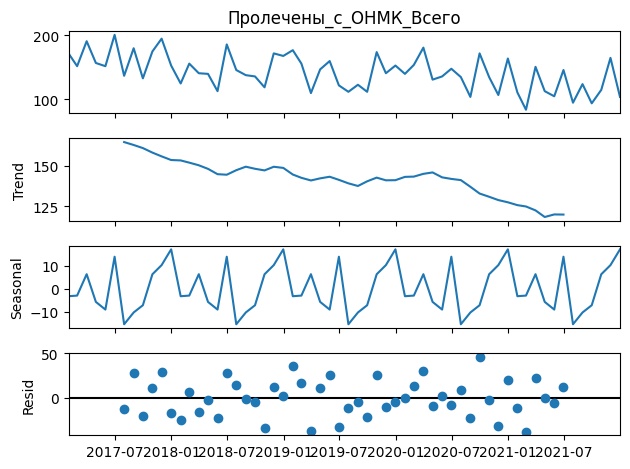

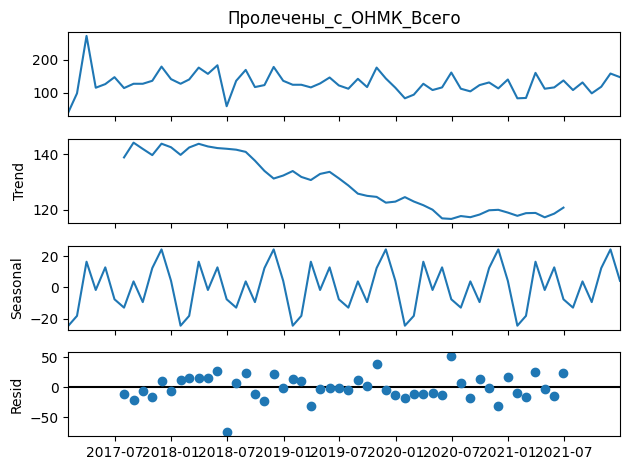

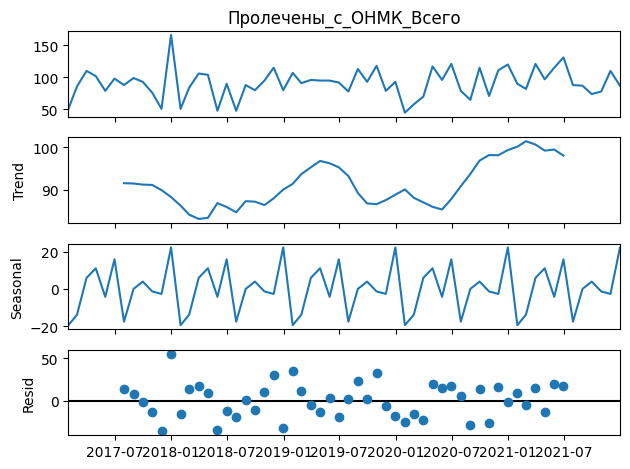

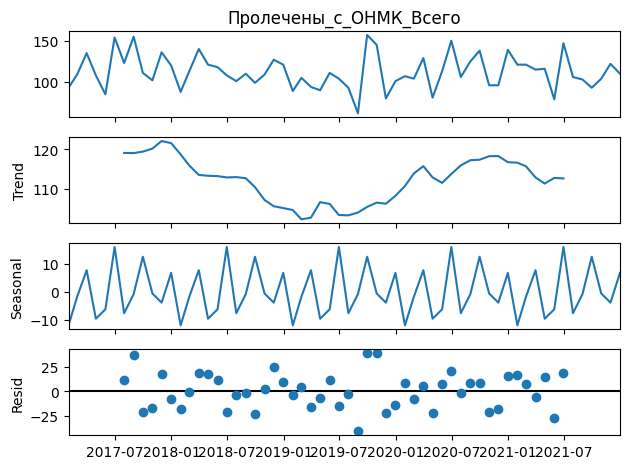

In [151]:
for i, hospital in enumerate(group_together_graph):
    # Data
    data_hosp = data_used.loc[data_used.hosp_graph == hospital]
    data_ts = data_hosp.loc[data_hosp.year.isin([2017, 2018, 2019, 2022, 2023])][['Пролечены_с_ОНМК_Всего', 'Date']]
    data_ts = pd.Series(data_ts['Пролечены_с_ОНМК_Всего'])
    data_ts.index = pd.date_range(start="2017-01-01", periods=60, freq="M")
    
    # Decompose the time series
    decomposition = seasonal_decompose(data_ts, model='additive', period=period)
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Calculate variances
    residual_variance = np.var(residual.dropna())
    seasonal_variance = np.var(seasonal.dropna())
    
    # Calculate Seasonal Strength
    seasonal_strength = 1 - (residual_variance / (residual_variance + seasonal_variance))
    
    print(f"*** {hospital} ***")
    print(f"Seasonal Strength: {seasonal_strength:.3f}")
    decomposition.plot()

# TMP

In [28]:
data_used

,hosp,type,year,month,Всего_с_ОНМК,Не_подтвержден_ОНМК,Госпитализированы_с_ОНМК,Пролечены_с_ОНМК_Всего,Внутрибольничные_ОНМК,ИИ_Ишемический_Инсульт,...,Летальные_Исходы,Летальные_Исходы_1_Сутки,Выписаны_Всего,Ривермид_1_Балл,Ривермид_2_4_Балла,Ривермид_5_8_Баллов,Ривермид_9_Баллов,Суммарная_Загрузка_ОНМК,Суммарно_Госпитализировано,Date
192,b15,3,2017,1,164.0,66.0,96.0,93.0,2.0,83.0,...,21.0,3.0,72.0,7.0,15.0,26.0,24.0,164.0,96.0,2017-01
193,b15,3,2017,2,181.0,73.0,104.0,109.0,6.0,100.0,...,26.0,3.0,83.0,8.0,15.0,31.0,29.0,181.0,104.0,2017-02
194,b15,3,2017,3,242.0,99.0,133.0,135.0,4.0,126.0,...,34.0,1.0,101.0,8.0,15.0,37.0,41.0,242.0,133.0,2017-03
195,b15,3,2017,4,189.0,83.0,101.0,108.0,5.0,100.0,...,26.0,4.0,82.0,5.0,12.0,33.0,32.0,189.0,101.0,2017-04
196,b15,3,2017,5,196.0,101.0,93.0,85.0,1.0,77.0,...,22.0,0.0,63.0,0.0,9.0,23.0,31.0,196.0,93.0,2017-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,gvv,3,2024,8,185.0,23.0,162.0,149.0,9.0,140.0,...,20.0,1.0,129.0,8.0,20.0,25.0,76.0,185.0,162.0,2024-08
1436,gvv,3,2024,9,106.0,9.0,97.0,117.0,5.0,112.0,...,11.0,2.0,106.0,14.0,13.0,28.0,51.0,106.0,97.0,2024-09
1437,gvv,3,2024,10,158.0,18.0,140.0,128.0,7.0,117.0,...,22.0,1.0,106.0,11.0,10.0,27.0,58.0,158.0,140.0,2024-10
1438,gvv,3,2024,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-11


In [32]:
data_used.loc'hosp == "bsp"')

,hosp,type,year,month,Всего_с_ОНМК,Не_подтвержден_ОНМК,Госпитализированы_с_ОНМК,Пролечены_с_ОНМК_Всего,Внутрибольничные_ОНМК,ИИ_Ишемический_Инсульт,...,Летальные_Исходы,Летальные_Исходы_1_Сутки,Выписаны_Всего,Ривермид_1_Балл,Ривермид_2_4_Балла,Ривермид_5_8_Баллов,Ривермид_9_Баллов,Суммарная_Загрузка_ОНМК,Суммарно_Госпитализировано,Date
1248,bsp,3,2017,1,120.0,117.0,0.0,172.0,7.0,134.0,...,46.0,1.0,126.0,3.0,13.0,55.0,55.0,120.0,0.0,2017-01
1249,bsp,3,2017,2,428.0,103.0,324.0,152.0,6.0,121.0,...,32.0,2.0,120.0,8.0,8.0,50.0,54.0,428.0,324.0,2017-02
1250,bsp,3,2017,3,299.0,141.0,153.0,191.0,6.0,159.0,...,36.0,1.0,155.0,7.0,13.0,65.0,70.0,299.0,153.0,2017-03
1251,bsp,3,2017,4,258.0,101.0,157.0,157.0,11.0,135.0,...,41.0,2.0,116.0,6.0,11.0,46.0,53.0,258.0,157.0,2017-04
1252,bsp,3,2017,5,242.0,85.0,152.0,152.0,2.0,118.0,...,25.0,3.0,127.0,1.0,12.0,53.0,61.0,242.0,152.0,2017-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,bsp,3,2024,8,228.0,102.0,126.0,126.0,35.0,114.0,...,40.0,0.0,86.0,4.0,7.0,29.0,46.0,228.0,126.0,2024-08
1340,bsp,3,2024,9,182.0,62.0,120.0,120.0,18.0,108.0,...,27.0,1.0,93.0,7.0,11.0,31.0,44.0,182.0,120.0,2024-09
1341,bsp,3,2024,10,247.0,85.0,162.0,162.0,8.0,150.0,...,32.0,1.0,130.0,5.0,19.0,43.0,63.0,247.0,162.0,2024-10
1342,bsp,3,2024,11,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-11
